In [125]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import pdist, squareform
import random
from sklearn.linear_model import LinearRegression
from matplotlib.colors import LogNorm
from sklearn.metrics import silhouette_score, r2_score

## Первичная обработка данных

In [126]:
X = pd.read_excel("data/X_4_14.xlsx", names=[f"feature_{i}" for i in range(4)])

In [127]:
X.describe()

feature_0   feature_1   feature_2   feature_3
count  199.000000  199.000000  199.000000  199.000000
mean     2.989366    0.978693    3.042654   -0.053288
std      2.667961    1.193916    2.627396    1.657722
min     -1.770611   -1.098890   -1.686545   -3.001601
25%      0.950759    0.094083    1.015519   -1.329454
50%      3.036132    1.012075    2.999677    0.001223
75%      5.021846    1.939613    5.048610    1.153452
max      7.684823    3.085918    8.097899    3.110166

#### Проверка на выбросы

In [128]:
X.isna().sum()

feature_0    0
feature_1    0
feature_2    0
feature_3    0
dtype: int64

<Axes: >

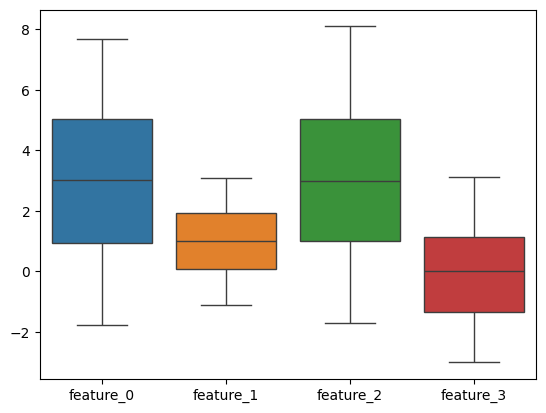

In [129]:
sns.boxplot(X)

In [130]:
X = MinMaxScaler().fit_transform(X)

<Axes: >

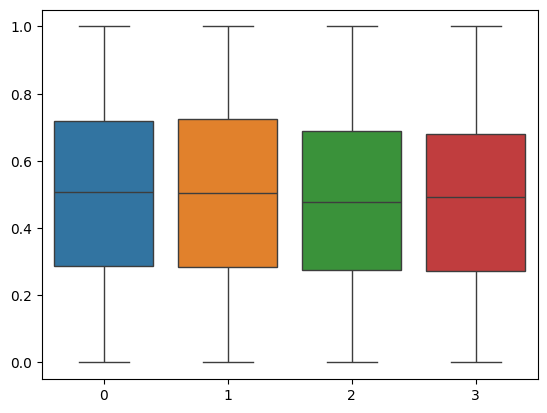

In [131]:
sns.boxplot(X)

Вложим наши наблюдения на двумерие с помощью PCA для визуализации

In [235]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_2d = pca.fit_transform(X)

In [236]:
pca.explained_variance_ratio_

array([0.66764066, 0.33235934])

In [ ]:
sum(pca.explained_variance_ratio_)

0.9999999999999999

Суммарная доля объясненной дисперсии по первым двум компонентам примерно равна 1, что означает, что выводы, сделанные при помощи визуального анализа двумерной карты будут вполне обоснованными.

<Axes: title={'center': 'Двумерная карта наблюдений'}, xlabel='pca_feature1', ylabel='pca_feature2'>

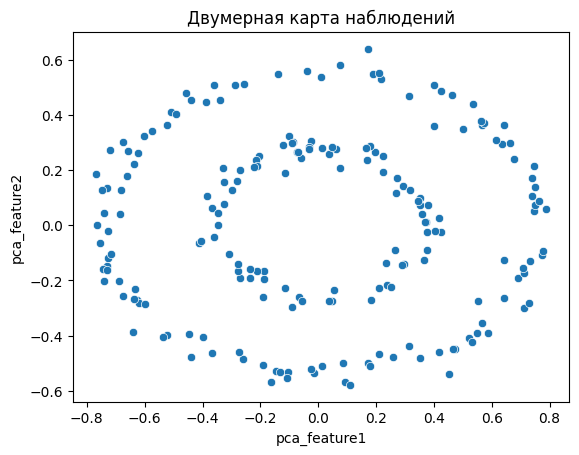

In [237]:
plt.title('Двумерная карта наблюдений')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1])

На двумерной карте можно выделить 2 кольцеобразных кластера разного радиуса, один из которых вложен в другой.

## Подготовка данных

#### Вычисление матрицы расстояний

In [134]:
def get_dist_matrix(matrix, metric="euclidean"):
    if metric == "minkowski":
        dist_vector = pdist(matrix, metric=metric, p=4)
    else:
        dist_vector = pdist(matrix, metric=metric)
    return squareform(dist_vector)

In [135]:
d_matrix_euclidean = get_dist_matrix(X, metric="euclidean")
d_matrix_minkowski = get_dist_matrix(X, metric="minkowski")
d_matrix_chebyshev = get_dist_matrix(X, metric="chebyshev")

#### Вычисление similarity-матрицы 

Каждый элемент матрицы схожести sim[i, j] = 1 / (1 + d[i, j]), где d - матрица расстояний в какой-либо метрике.

In [136]:
def get_similarity_matrix(d_matrix):
    sim_matrix = 1 / (1 + d_matrix)
    return sim_matrix

In [137]:
sim_matrix = get_similarity_matrix(d_matrix_euclidean)
sim_matrix_minkowski = get_similarity_matrix(d_matrix_minkowski)
sim_matrix_chebyshev = get_similarity_matrix(d_matrix_chebyshev)

Визуализируем матрицу схожестей, построенную на евклидовом расстоянии

<Axes: >

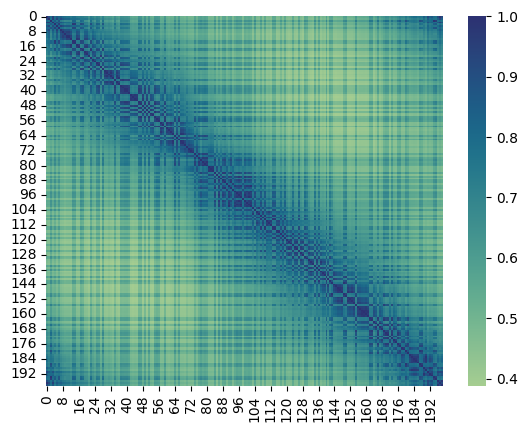

In [138]:
sns.heatmap(sim_matrix, cmap="crest")

Таким образом мы перешли к графовой модели, представленной матрицей схожести. Наблюдения из начальной таблицы стали вершинами графа, а схожесть наблюдений с индексами i и j - ребрами. Значение элемента [i, j] матрицы sim_matrix является весом ребра между вершинами i и j в нашем графе.

## Кластеризация для числа кластеров k=2

#### Кластеризация методом MST

Для кластеризации этим методом мы используем библиотеку networkx. Мы инициализируем граф и находим для него MST с помощью метода maximum_spanning_tree из этой библиотеки. Этот метод использует алгоритм Краскала для нахождения MST.

In [139]:
def MST_clustering(n_clusters, sim_matrix):
    G = nx.Graph()
    num_points = X.shape[0]

    # Добавляем узлы
    G.add_nodes_from(range(num_points))

    # Добавляем рёбра с весами
    for i in range(num_points):
        for j in range(i + 1, num_points):
            G.add_edge(i, j, weight=sim_matrix[i, j])

    # Построение максимального остовного дерева (MST) алгоритмом Краскала
    mst = nx.maximum_spanning_tree(G)
    
    # Рисуем MST
    plt.figure(figsize=(20, 30))
    plt.title("Граф MST")
    nx.draw_planar(mst, node_color="skyblue", edge_color="blue", with_labels=True, width=2)
    plt.show()

    # Удаление самого короткого ребра
    for i in range(n_clusters - 1):
        sorted_edges = sorted(mst.edges(data=True), key=lambda x: x[2]["weight"])
        shortest_edge = sorted_edges[0]  # самое короткое ребро
        mst.remove_edge(shortest_edge[0], shortest_edge[1])
        # print(shortest_edge[0], shortest_edge[1])

    # Получаем компоненты связности
    clusters_mst = list(nx.connected_components(mst))

    plt.figure(figsize=(25, 15))

    for i, cluster in enumerate(clusters_mst, start=1):
        subgraph = mst.subgraph(cluster)  # Создаём подграф для кластера

        plt.subplot(1, n_clusters, i)
        nx.draw_planar(
            subgraph,
            with_labels=True,
            node_color="skyblue",
            edge_color="blue",
            node_size=700,
            font_weight="bold",
        )
        plt.title(f"Граф кластера {i}")
        plt.xlabel("X")
        plt.ylabel("Y")

    plt.tight_layout()
    plt.show()

    for i, cluster in enumerate(clusters_mst, start=1):
        print(f"Кластер {i}: {sorted(cluster)}")

    return G, clusters_mst

Кластеризация с использованием матрицы схожестей на основе матрицы евклидовых расстояний

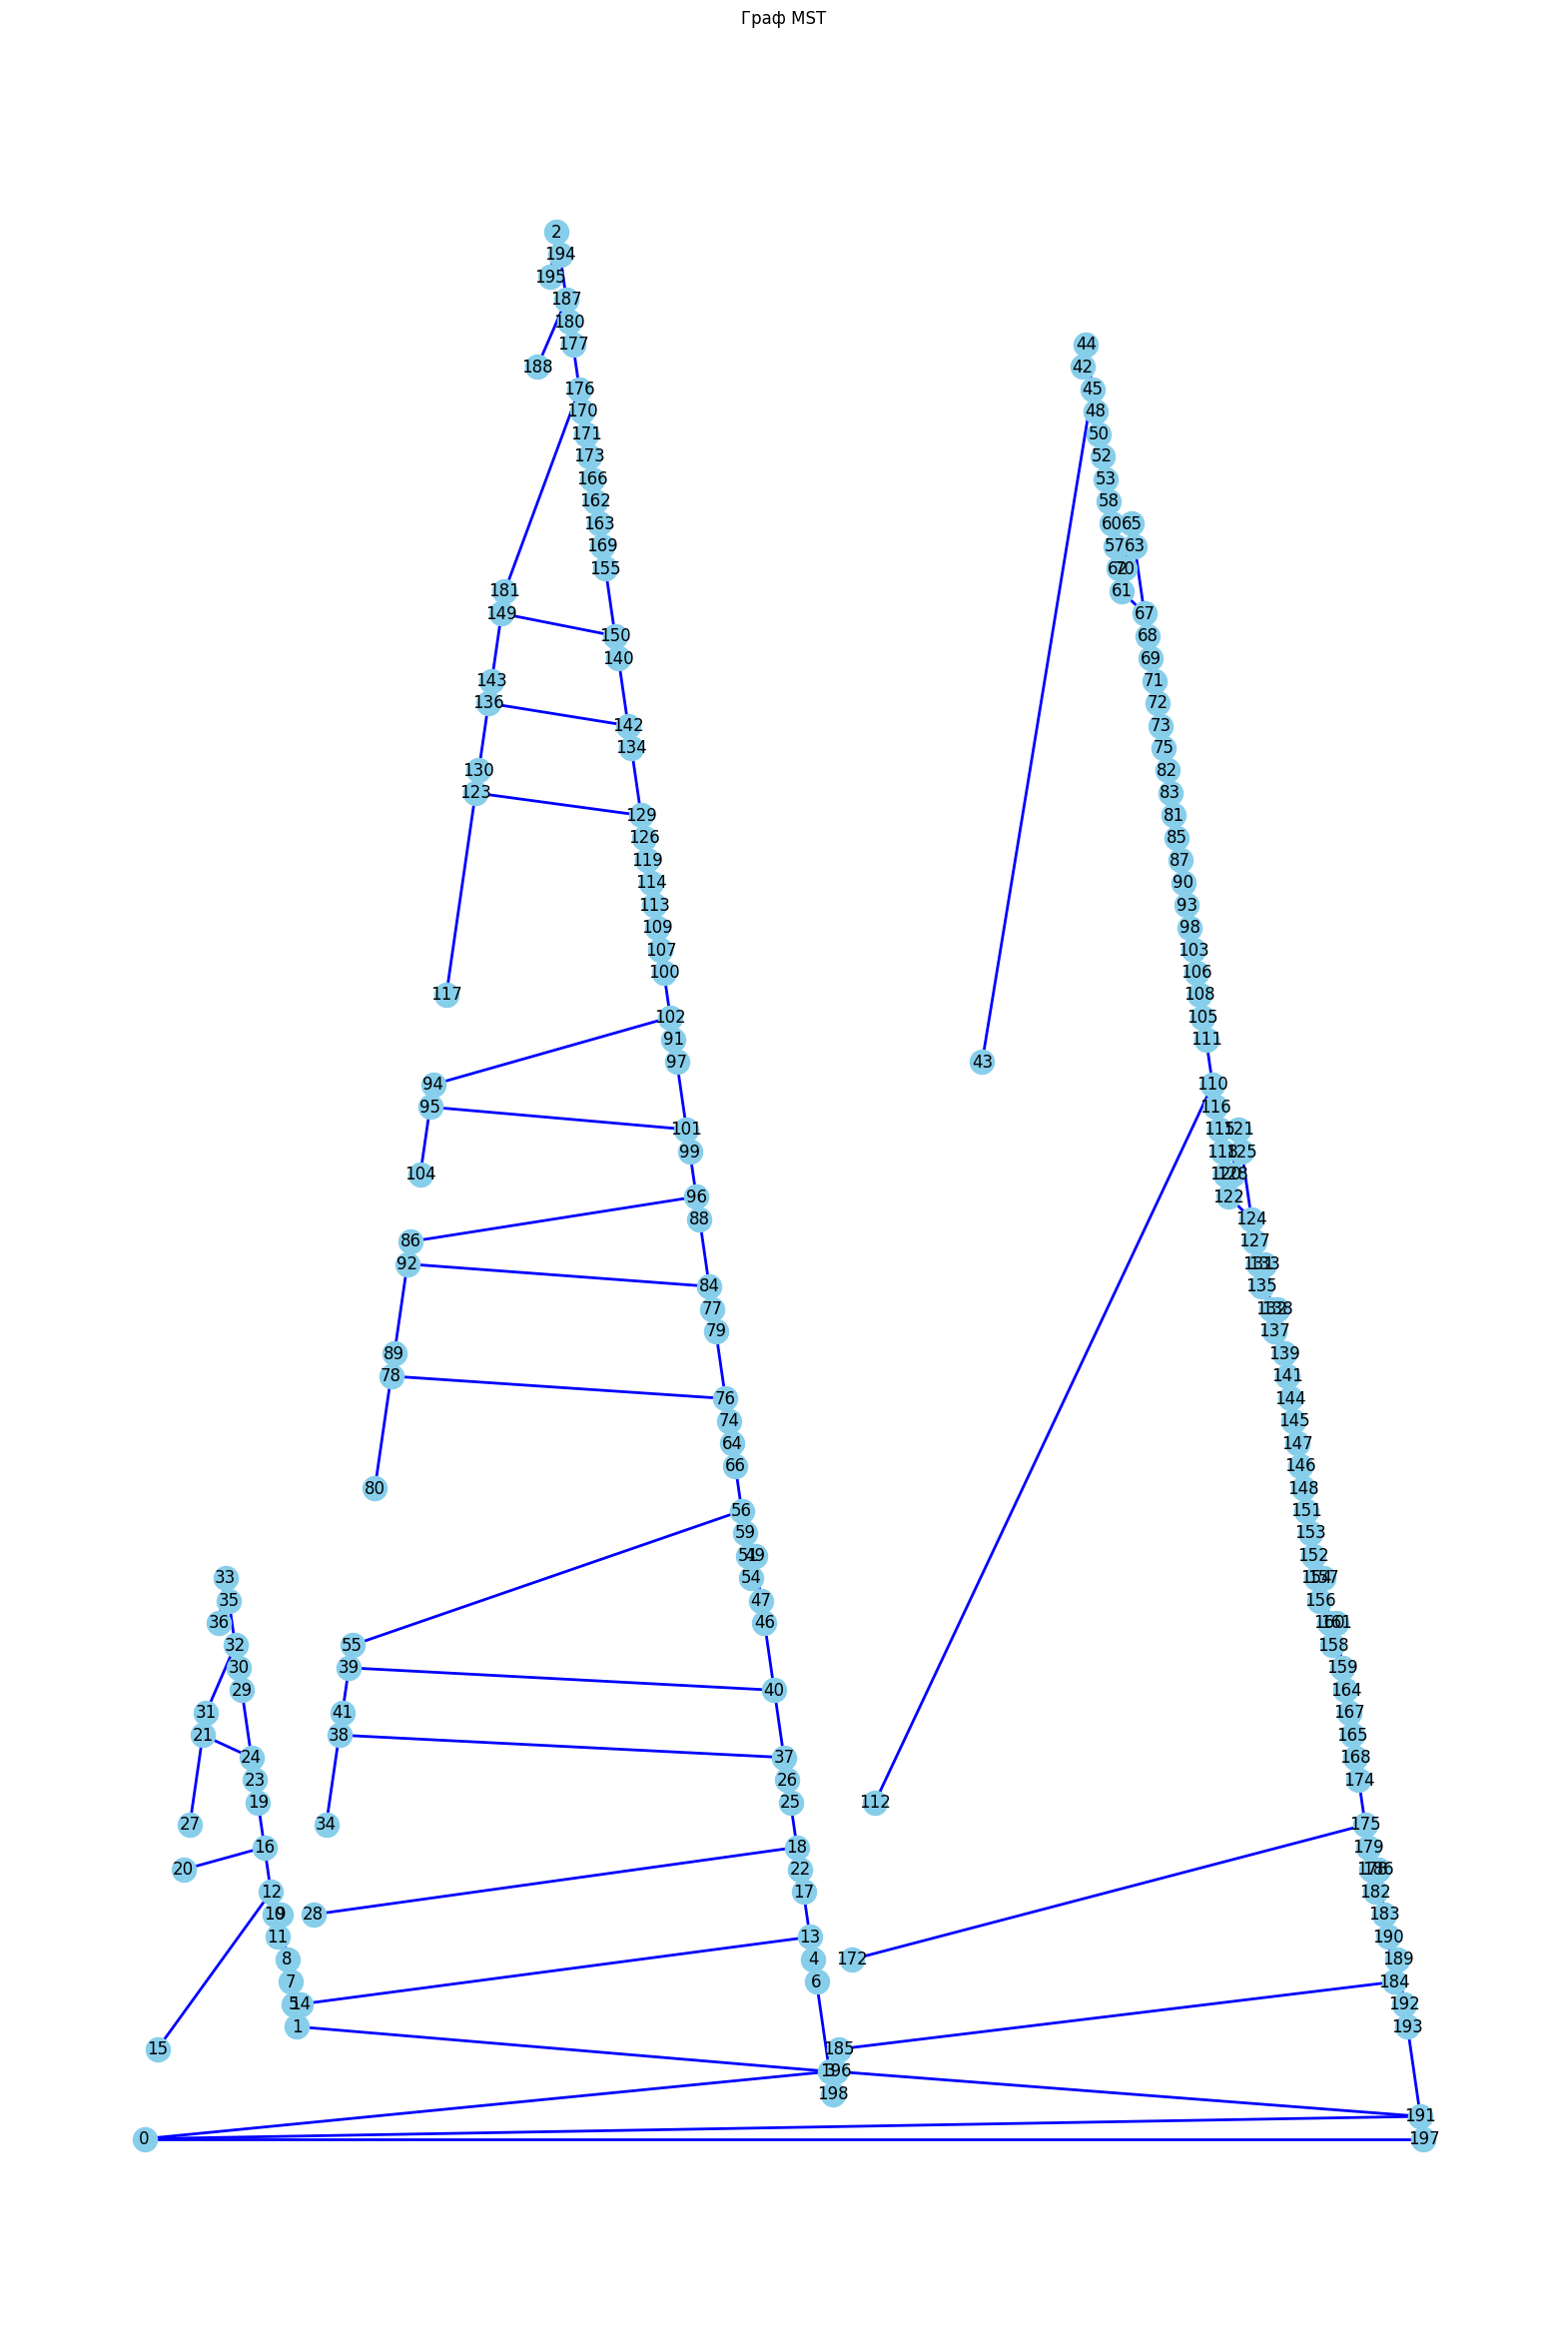

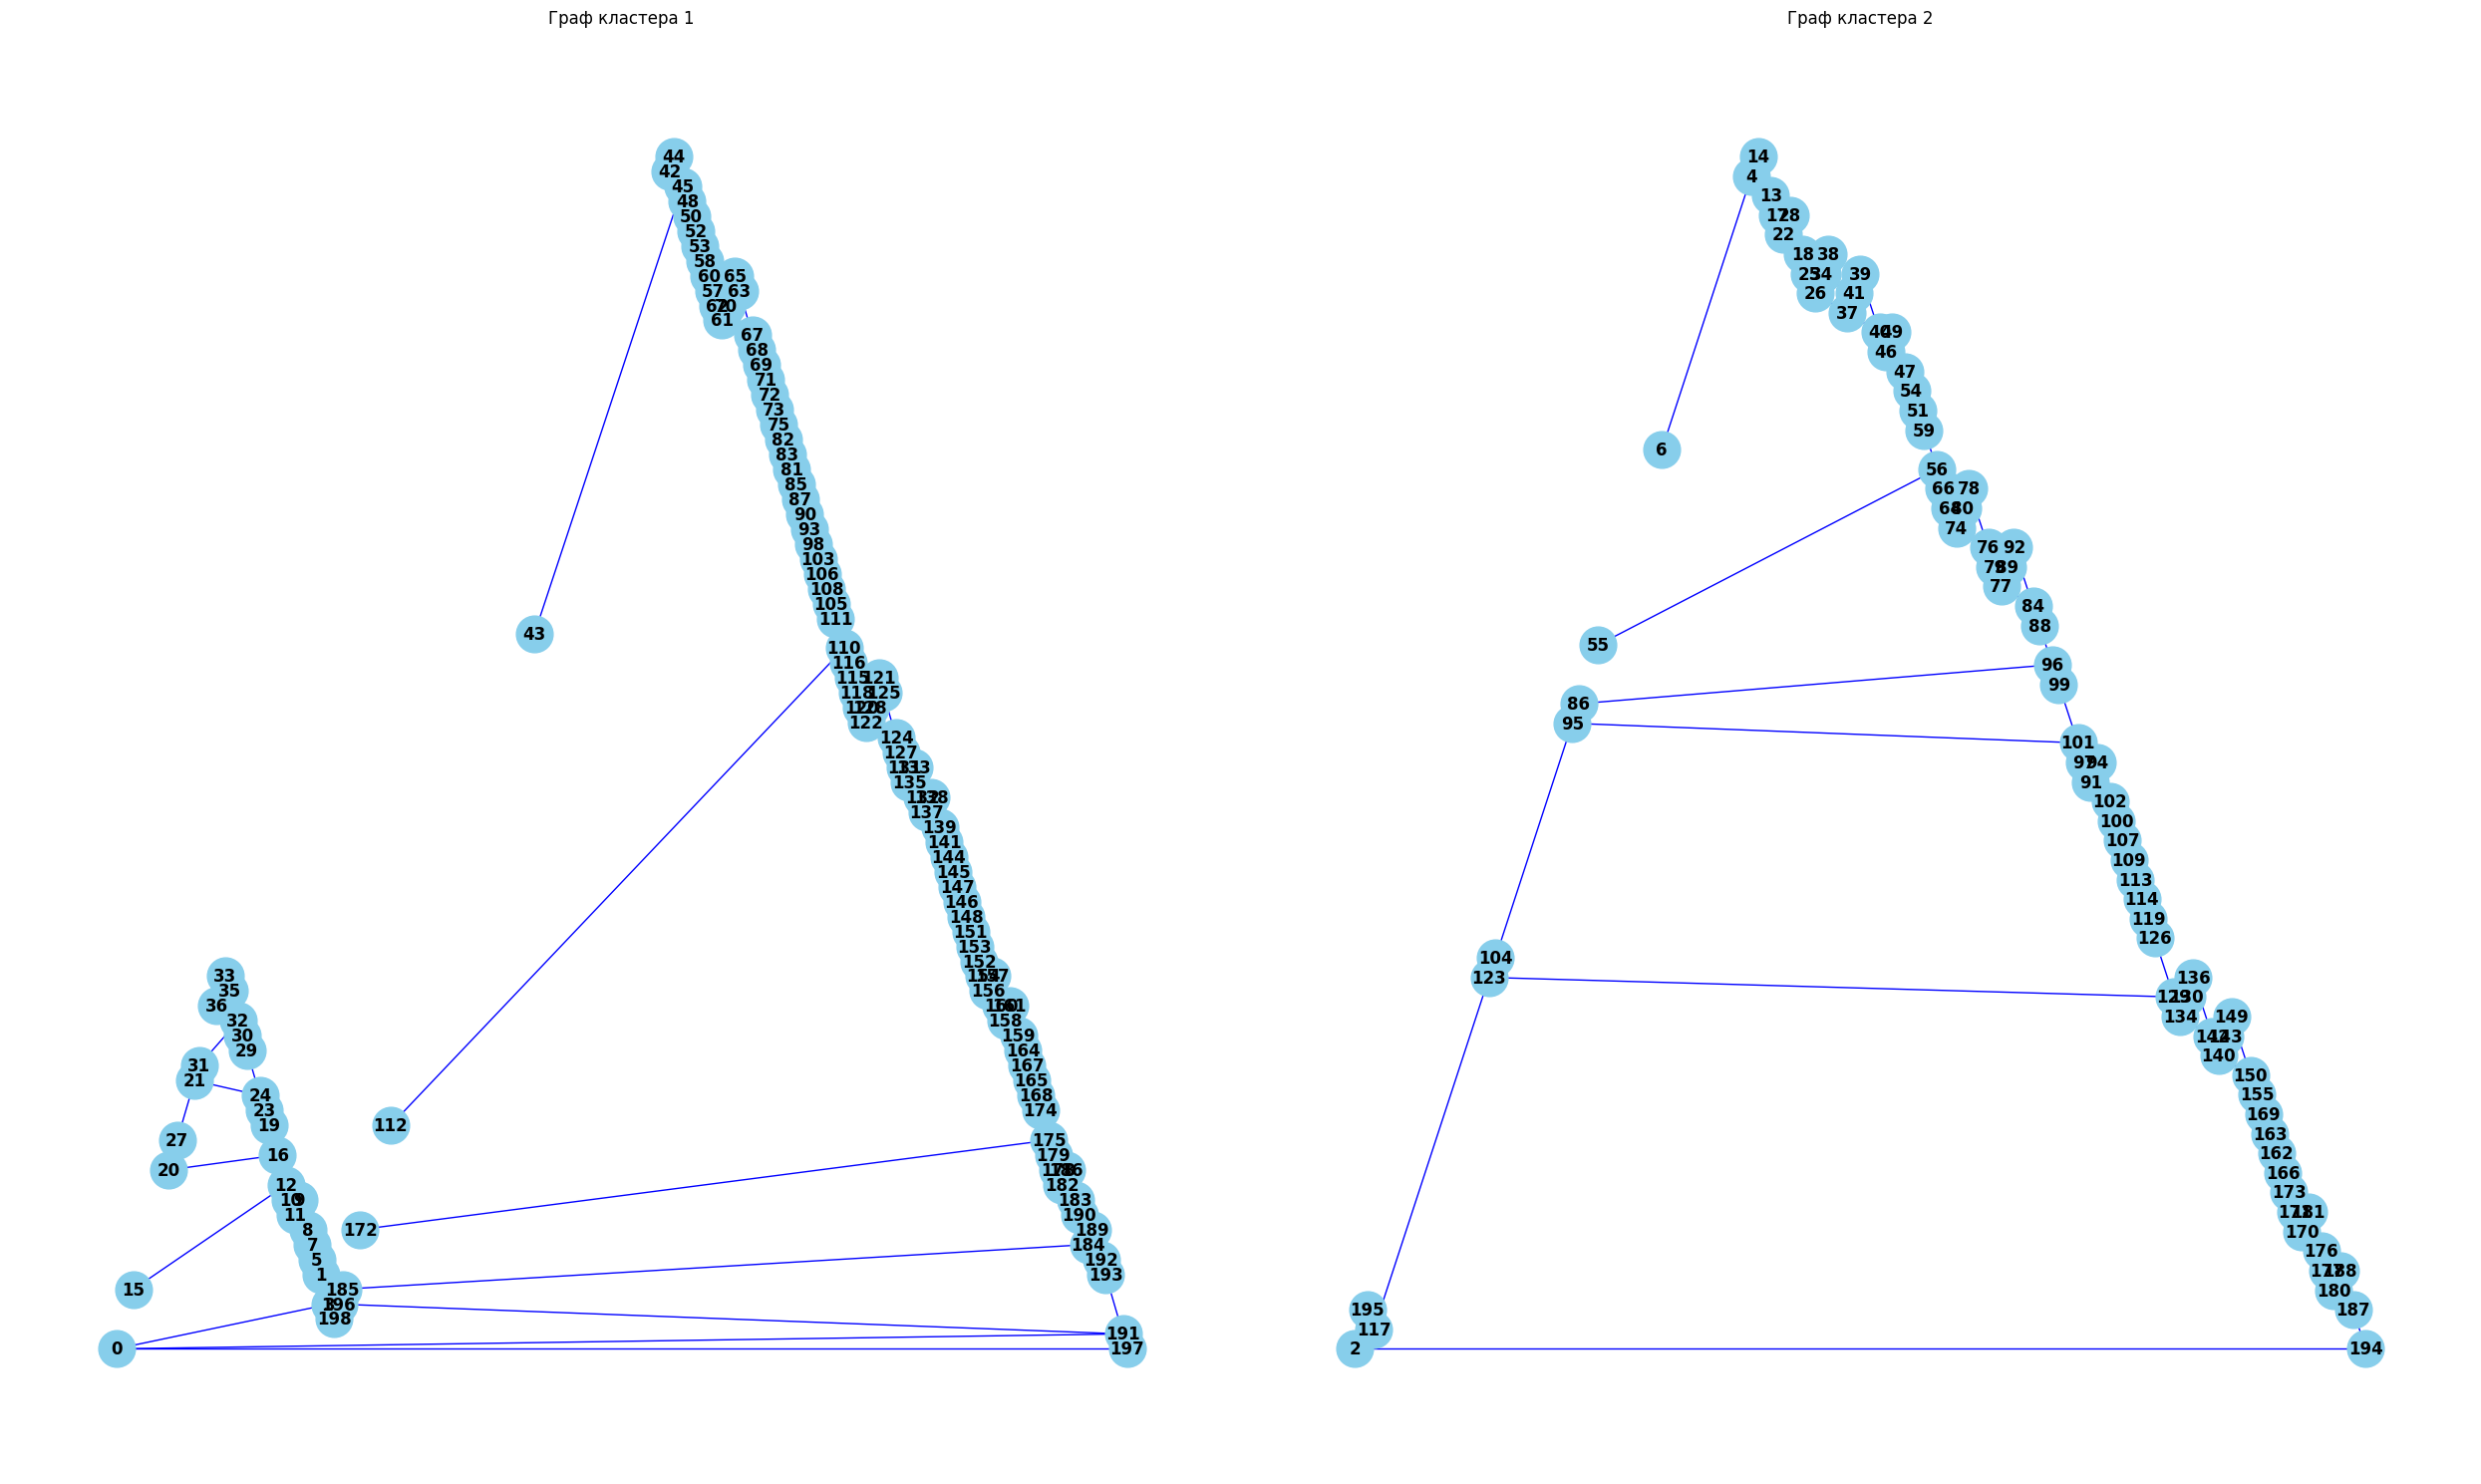

Кластер 1: [0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 19, 20, 21, 23, 24, 27, 29, 30, 31, 32, 33, 35, 36, 42, 43, 44, 45, 48, 50, 52, 53, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 75, 81, 82, 83, 85, 87, 90, 93, 98, 103, 105, 106, 108, 110, 111, 112, 115, 116, 118, 120, 121, 122, 124, 125, 127, 128, 131, 132, 133, 135, 137, 138, 139, 141, 144, 145, 146, 147, 148, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 164, 165, 167, 168, 172, 174, 175, 178, 179, 182, 183, 184, 185, 186, 189, 190, 191, 192, 193, 196, 197, 198]
Кластер 2: [2, 4, 6, 13, 14, 17, 18, 22, 25, 26, 28, 34, 37, 38, 39, 40, 41, 46, 47, 49, 51, 54, 55, 56, 59, 64, 66, 74, 76, 77, 78, 79, 80, 84, 86, 88, 89, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 104, 107, 109, 113, 114, 117, 119, 123, 126, 129, 130, 134, 136, 140, 142, 143, 149, 150, 155, 162, 163, 166, 169, 170, 171, 173, 176, 177, 180, 181, 187, 188, 194, 195]


In [140]:
G, clusters_mst = MST_clustering(2, sim_matrix)

Удаление ребра из MST привело к выделению 2 компонент связности, проверим, совпадают ли они с визуально выделенными кольцами. 

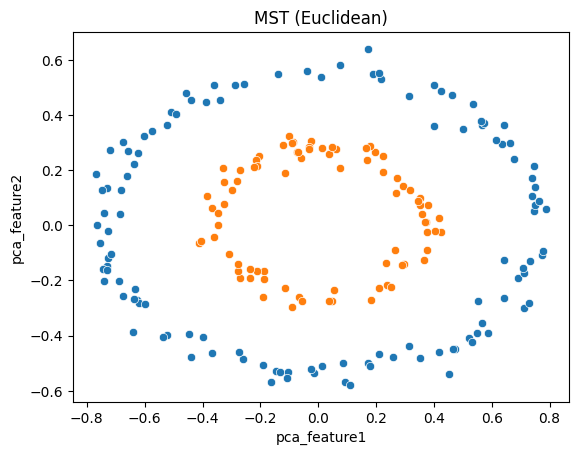

In [141]:
plt.title('MST (Euclidean)')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_mst)):
    sns.scatterplot(x=data_2d[list(clusters_mst[i])][:, 0], y=data_2d[list(clusters_mst[i])][:, 1])

Кластеризация с использованием матрицы схожестей на основе матрицы расстояний Минковского (p=4)

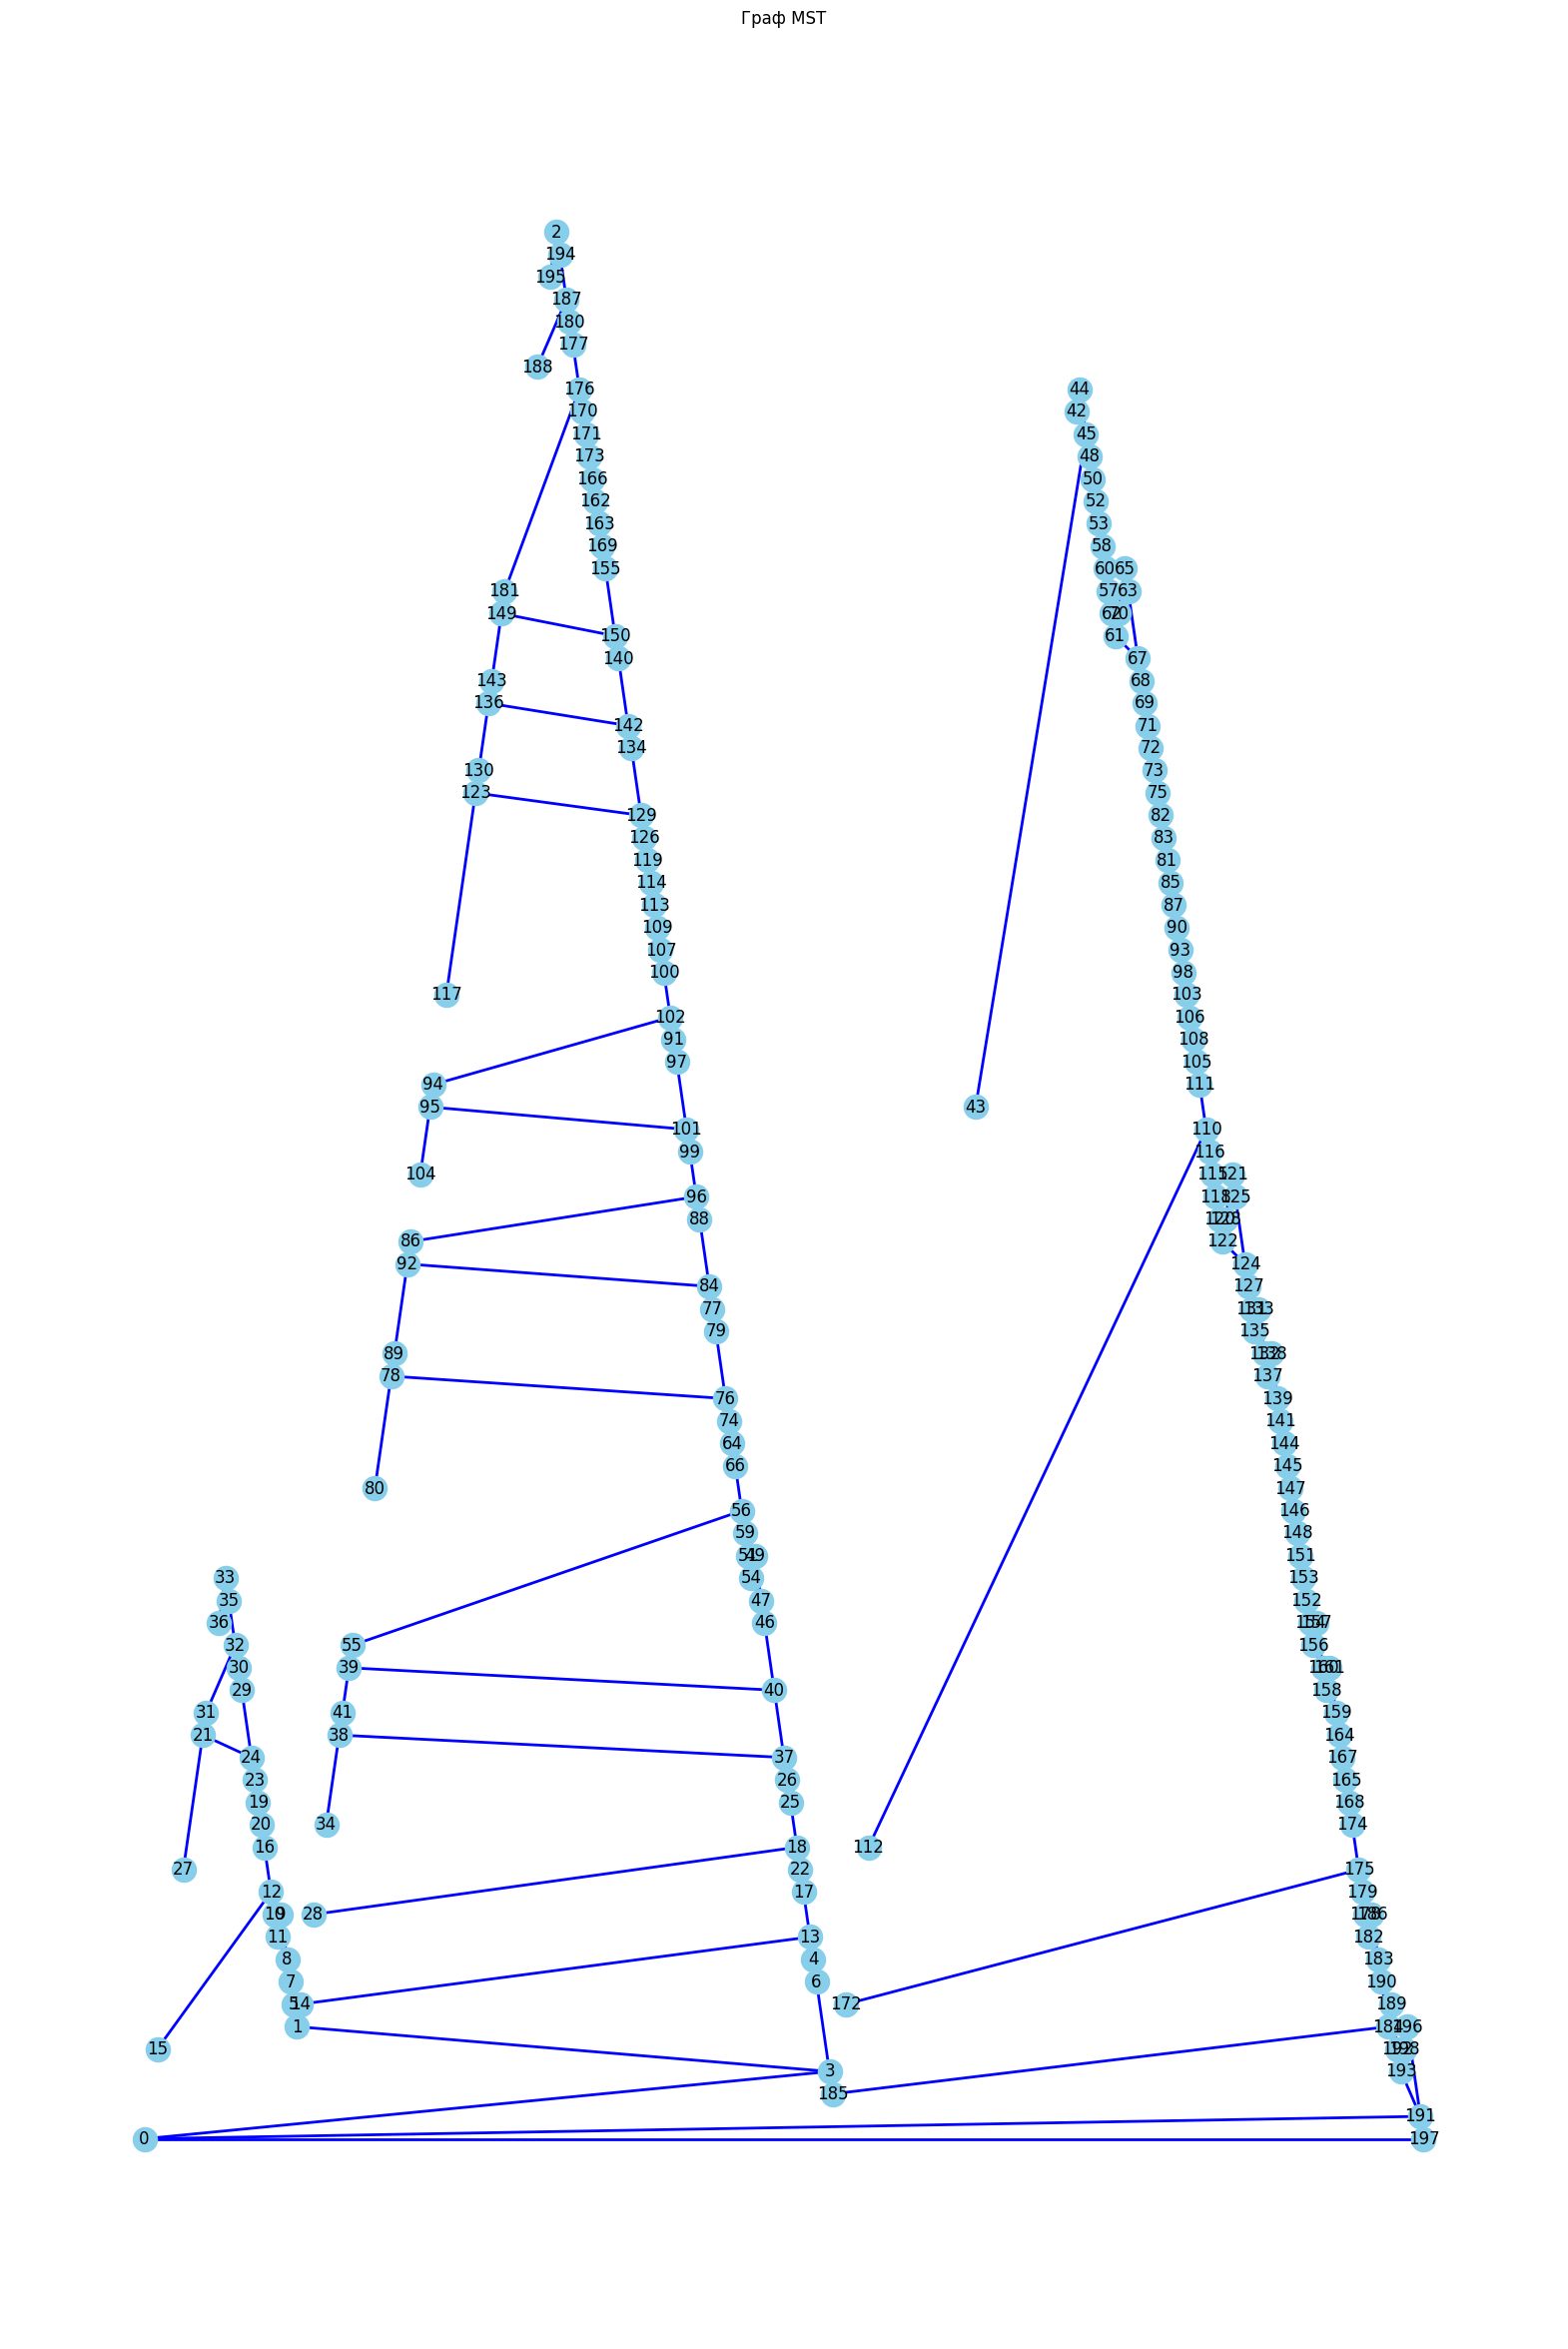

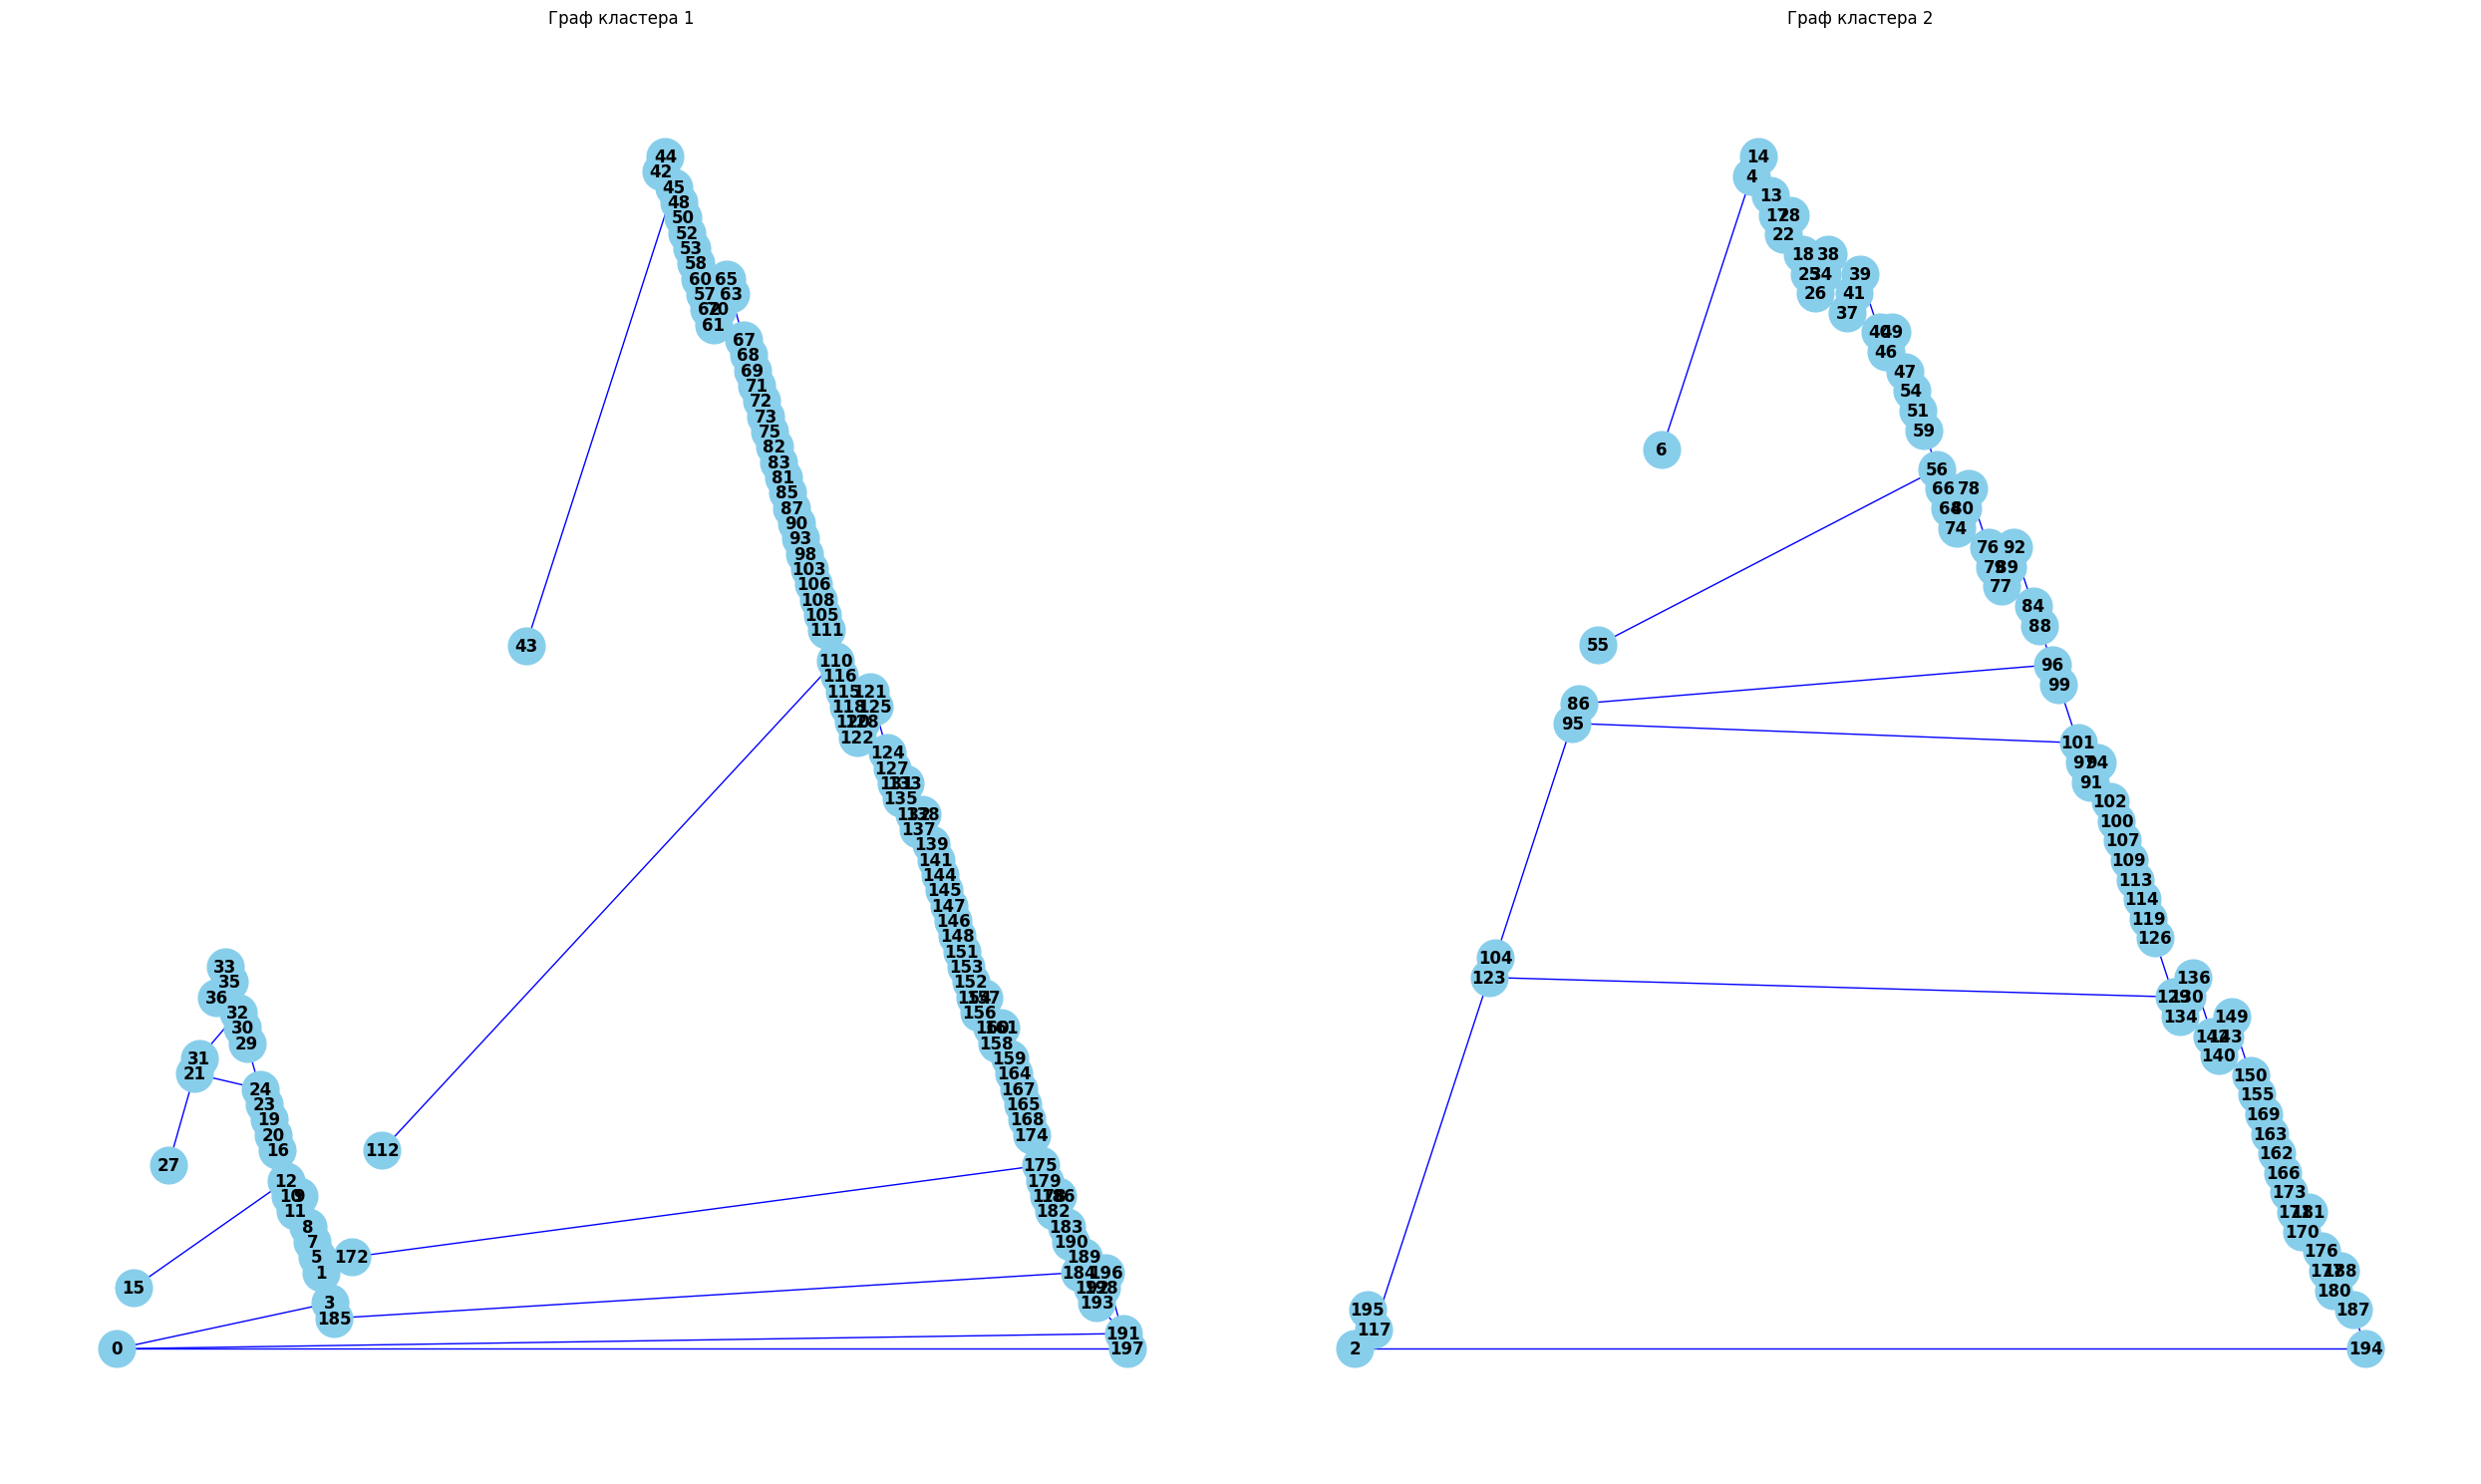

Кластер 1: [0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 19, 20, 21, 23, 24, 27, 29, 30, 31, 32, 33, 35, 36, 42, 43, 44, 45, 48, 50, 52, 53, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 75, 81, 82, 83, 85, 87, 90, 93, 98, 103, 105, 106, 108, 110, 111, 112, 115, 116, 118, 120, 121, 122, 124, 125, 127, 128, 131, 132, 133, 135, 137, 138, 139, 141, 144, 145, 146, 147, 148, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 164, 165, 167, 168, 172, 174, 175, 178, 179, 182, 183, 184, 185, 186, 189, 190, 191, 192, 193, 196, 197, 198]
Кластер 2: [2, 4, 6, 13, 14, 17, 18, 22, 25, 26, 28, 34, 37, 38, 39, 40, 41, 46, 47, 49, 51, 54, 55, 56, 59, 64, 66, 74, 76, 77, 78, 79, 80, 84, 86, 88, 89, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 104, 107, 109, 113, 114, 117, 119, 123, 126, 129, 130, 134, 136, 140, 142, 143, 149, 150, 155, 162, 163, 166, 169, 170, 171, 173, 176, 177, 180, 181, 187, 188, 194, 195]


In [142]:
G, clusters_mst = MST_clustering(2, sim_matrix_minkowski)

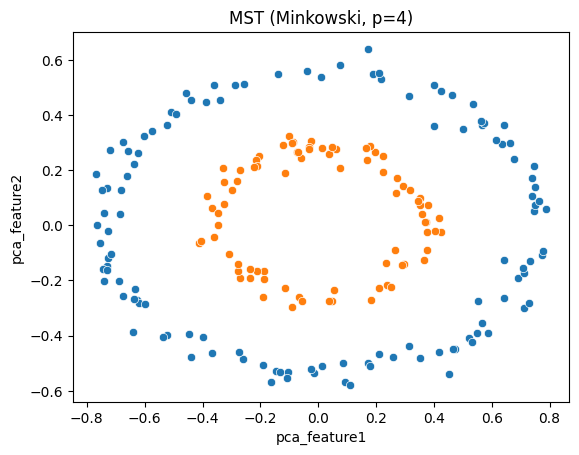

In [143]:
plt.title('MST (Minkowski, p=4)')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_mst)):
    sns.scatterplot(x=data_2d[list(clusters_mst[i])][:, 0], y=data_2d[list(clusters_mst[i])][:, 1])

Кластеризация с использованием матрицы схожестей на основе матрицы расстояний Чебышева

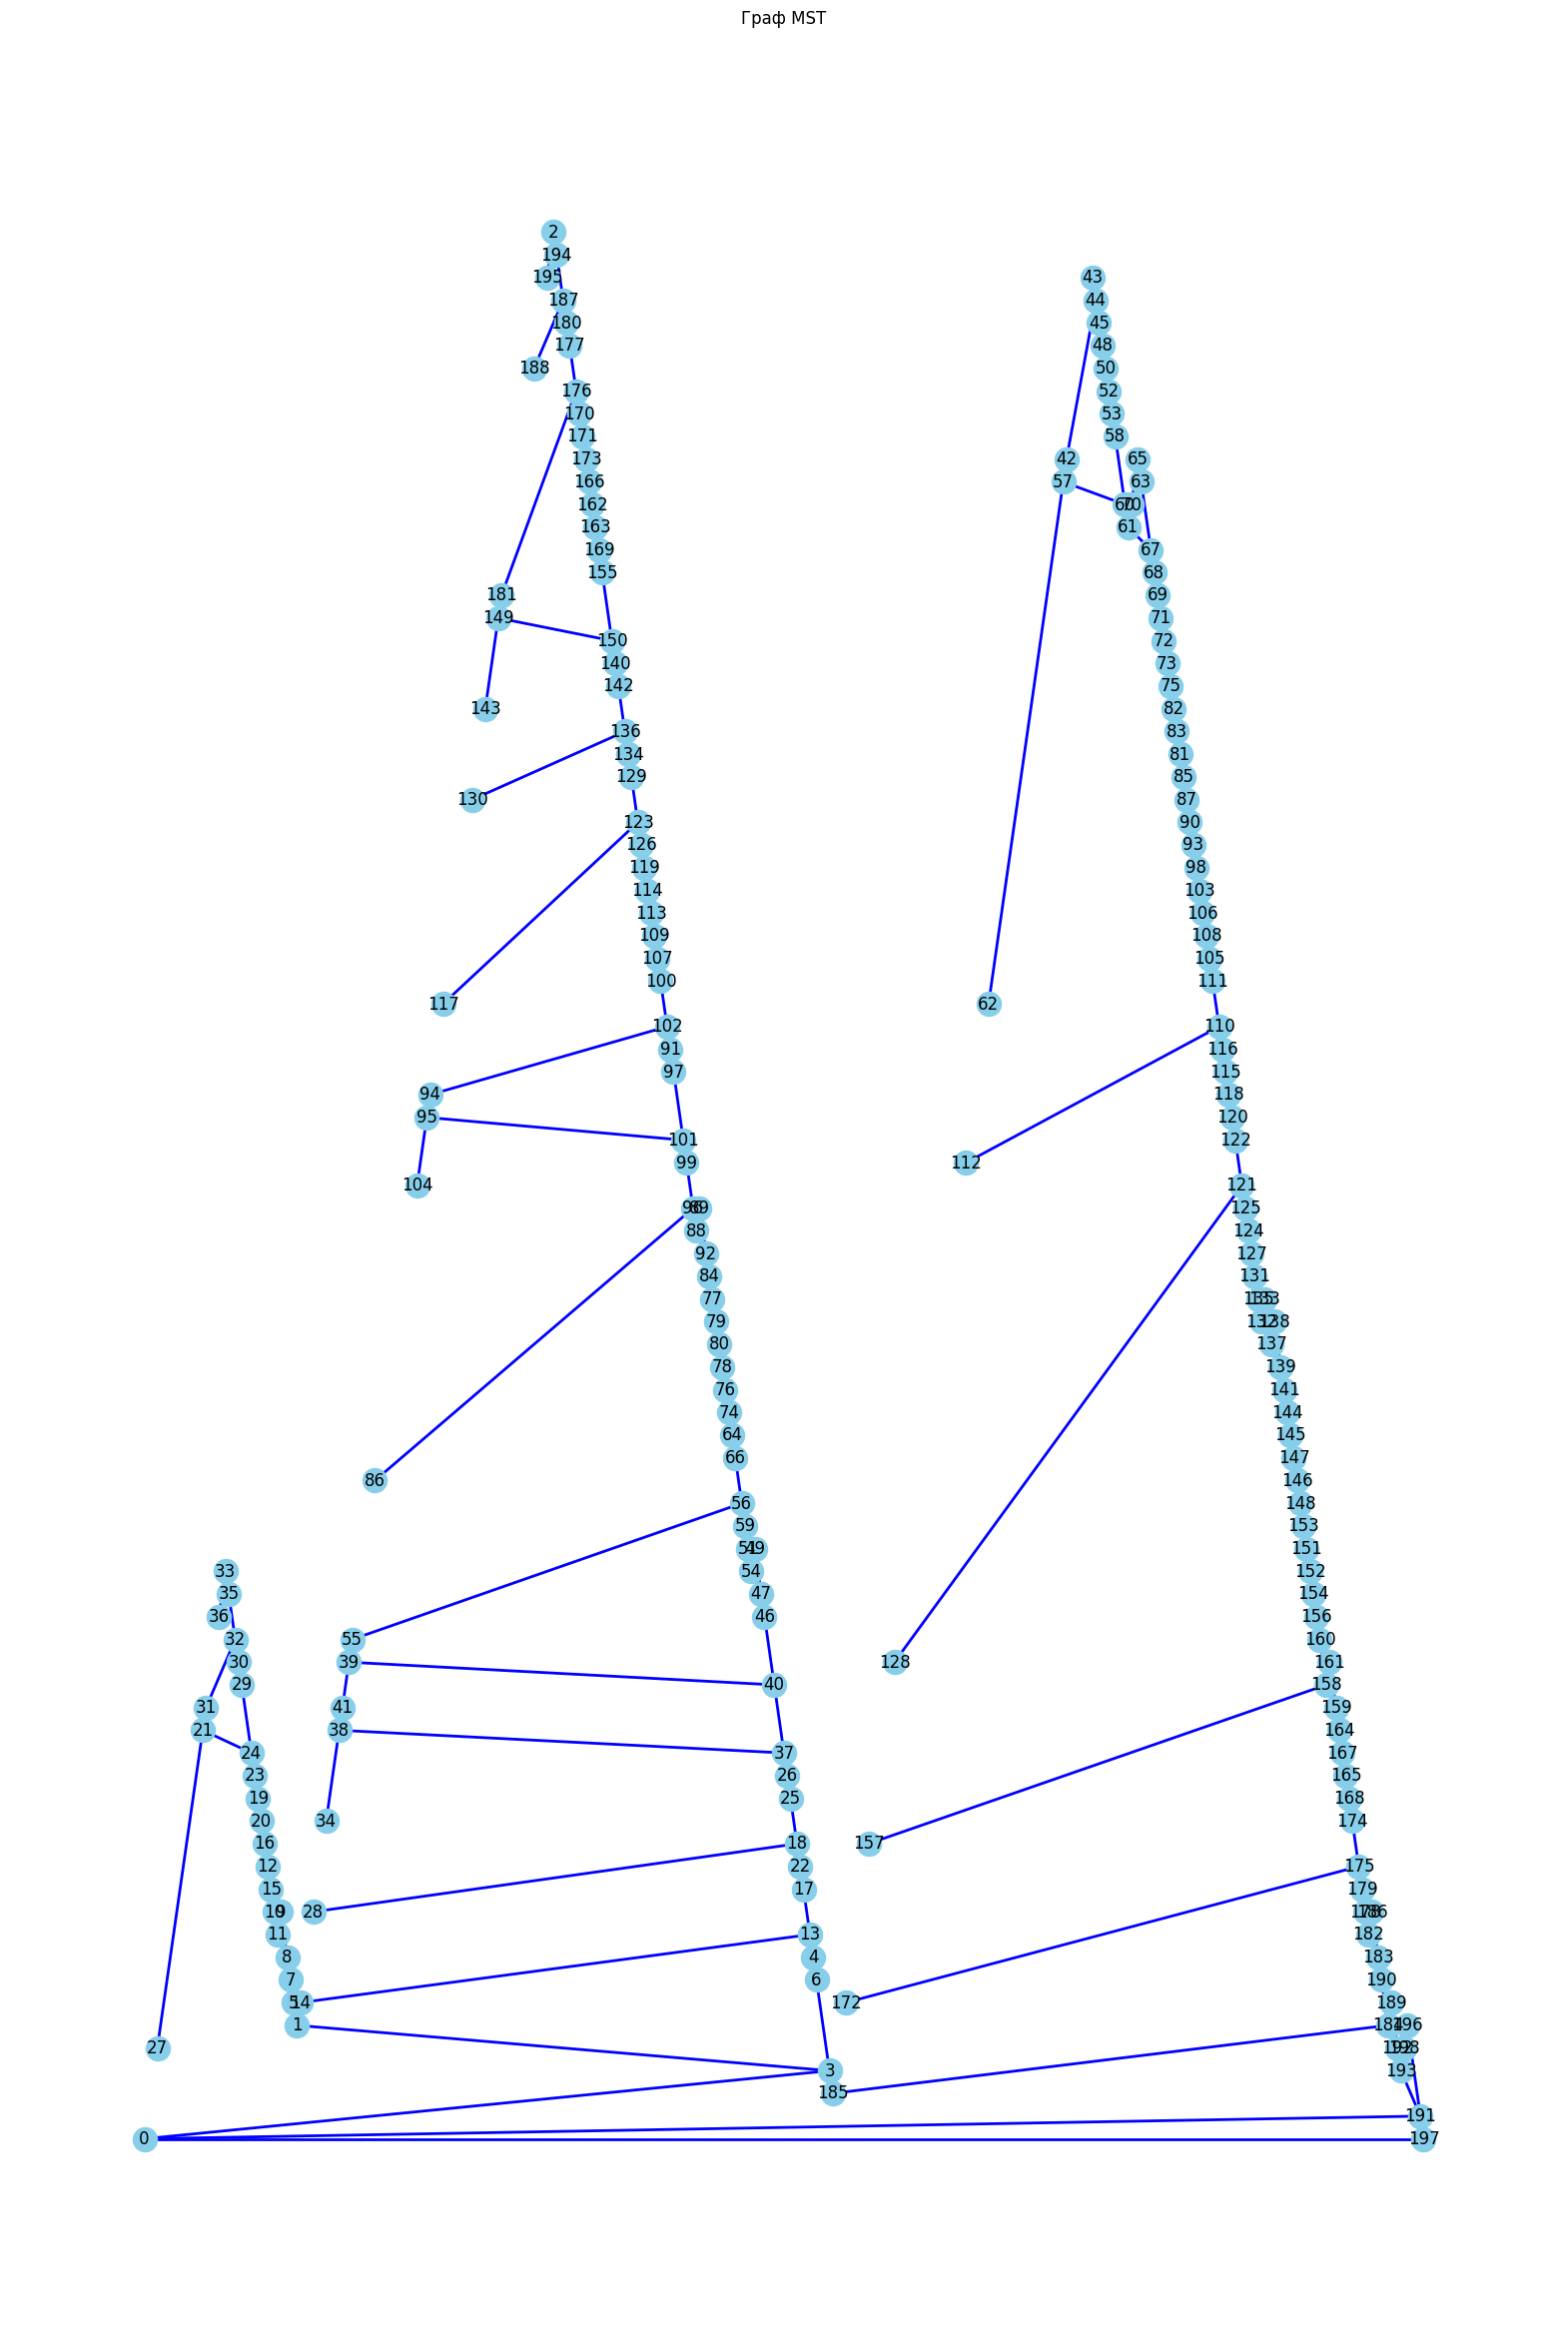

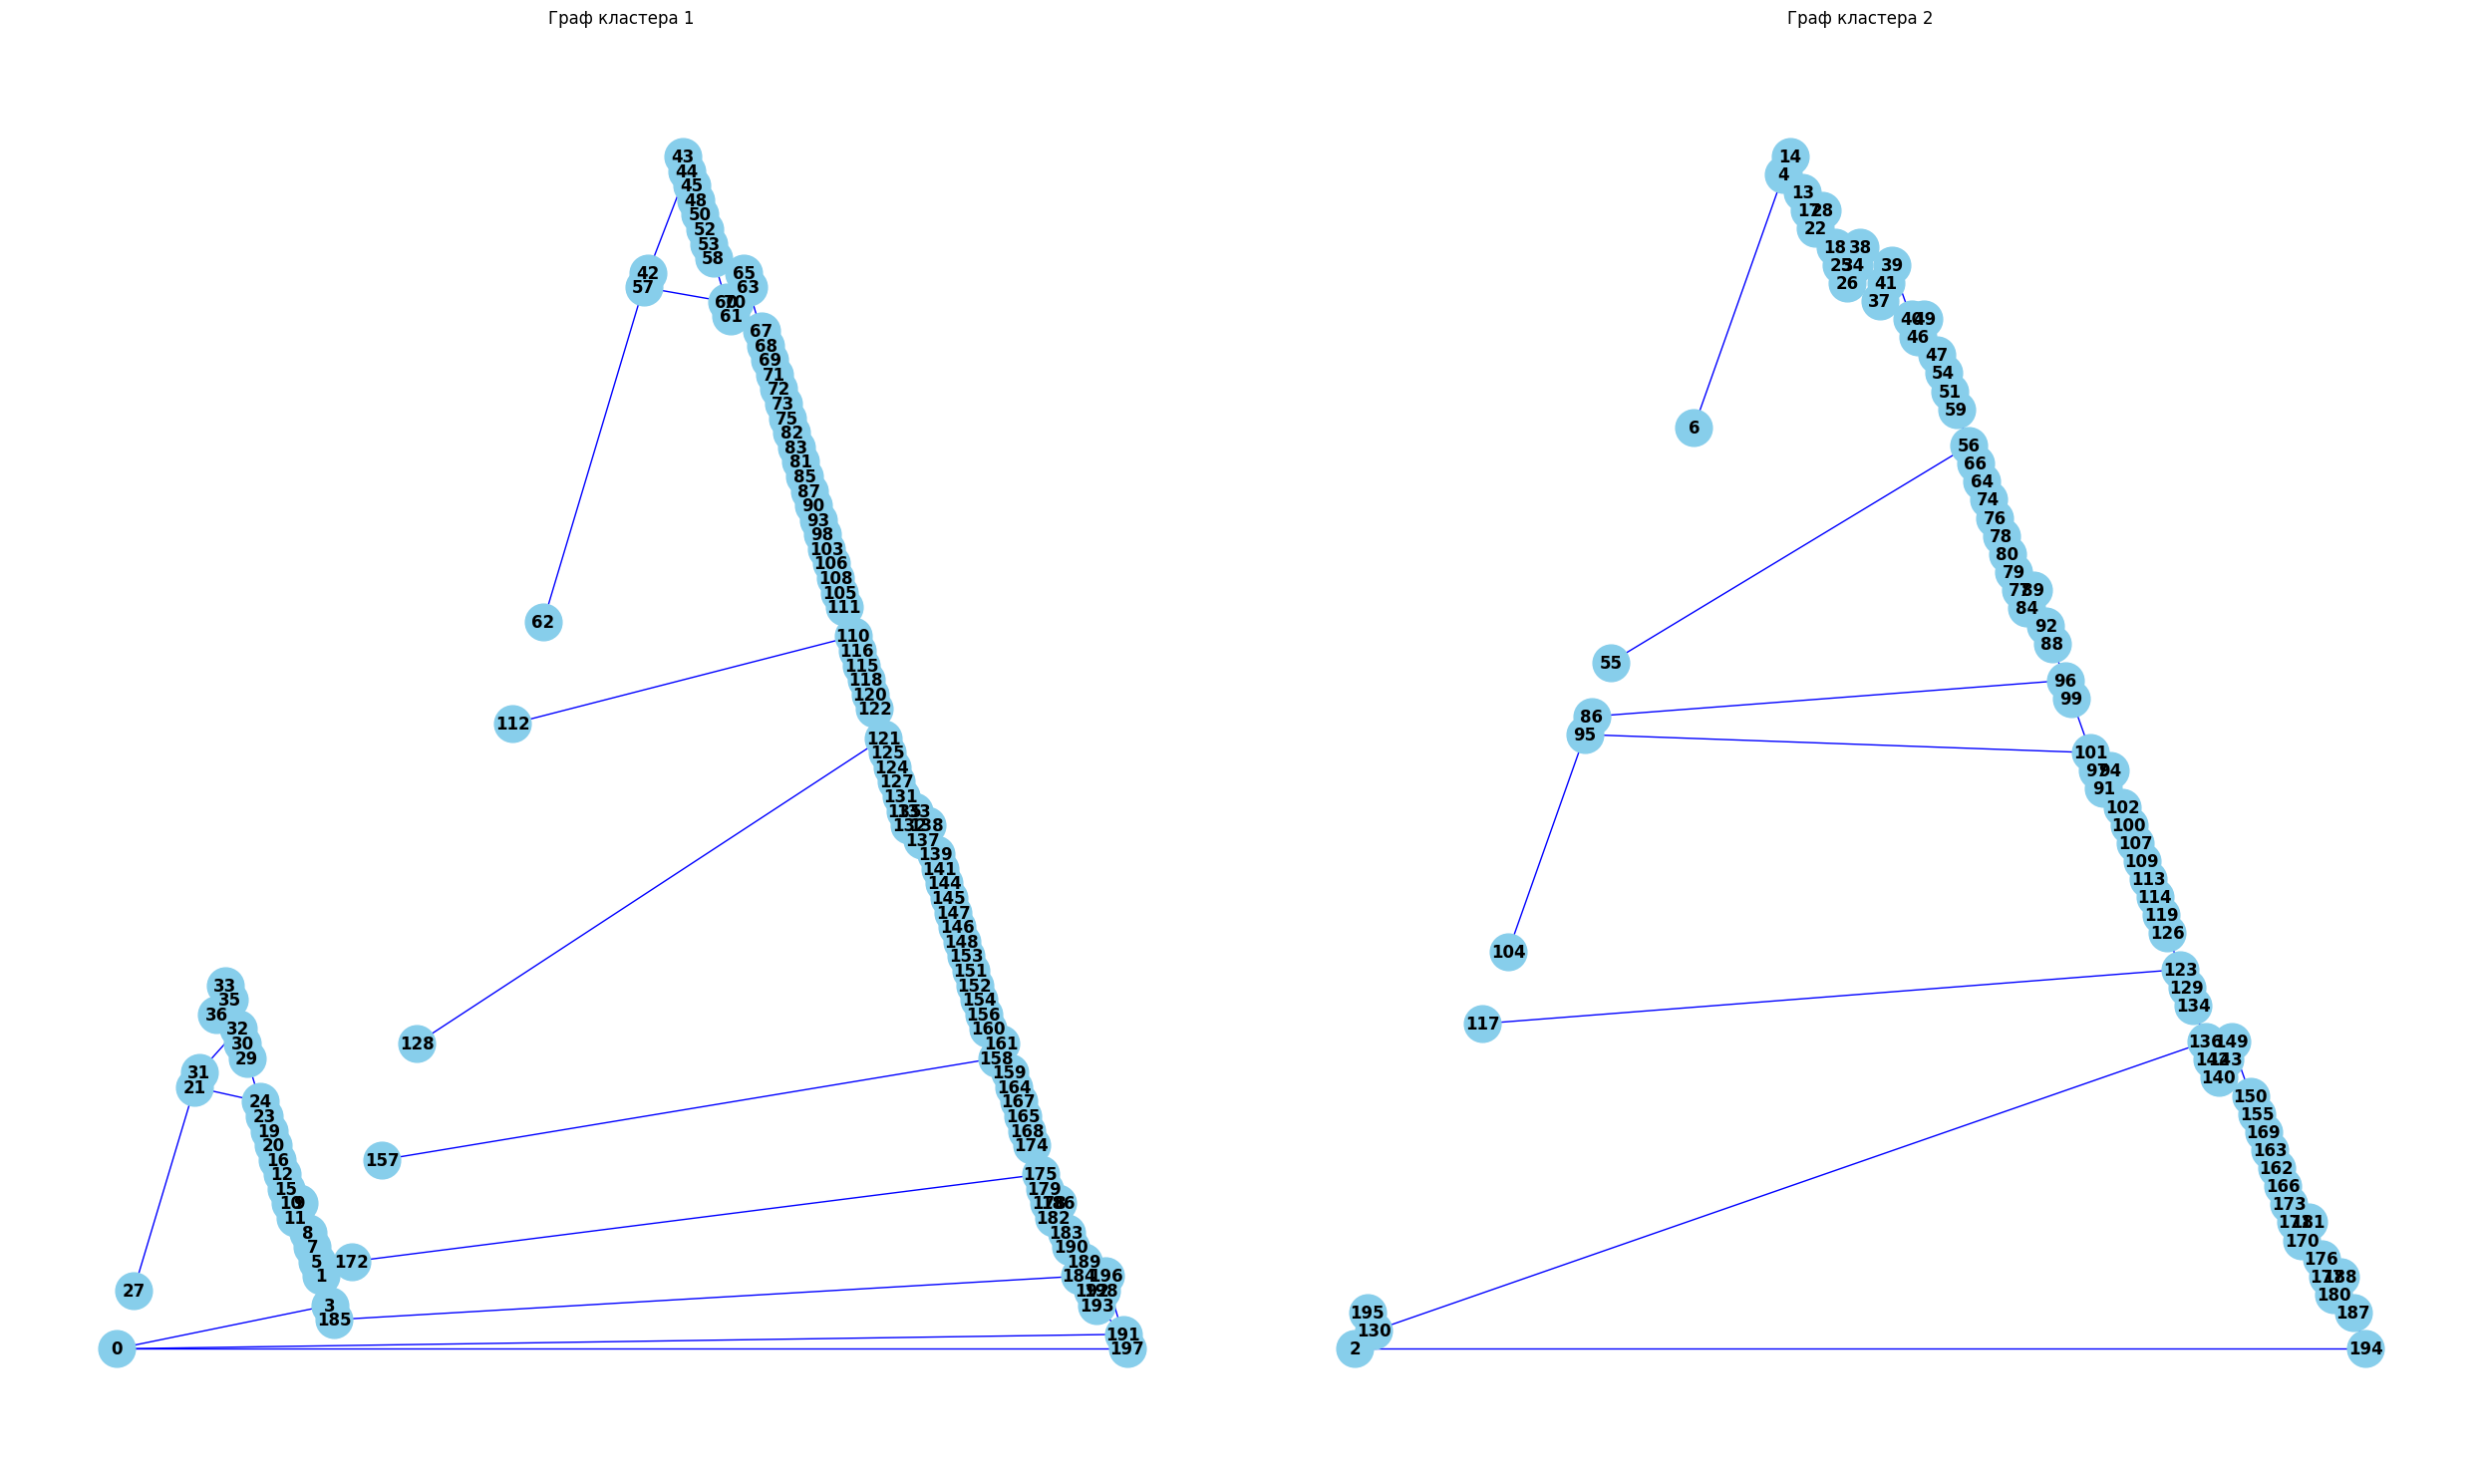

Кластер 1: [0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 19, 20, 21, 23, 24, 27, 29, 30, 31, 32, 33, 35, 36, 42, 43, 44, 45, 48, 50, 52, 53, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 75, 81, 82, 83, 85, 87, 90, 93, 98, 103, 105, 106, 108, 110, 111, 112, 115, 116, 118, 120, 121, 122, 124, 125, 127, 128, 131, 132, 133, 135, 137, 138, 139, 141, 144, 145, 146, 147, 148, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 164, 165, 167, 168, 172, 174, 175, 178, 179, 182, 183, 184, 185, 186, 189, 190, 191, 192, 193, 196, 197, 198]
Кластер 2: [2, 4, 6, 13, 14, 17, 18, 22, 25, 26, 28, 34, 37, 38, 39, 40, 41, 46, 47, 49, 51, 54, 55, 56, 59, 64, 66, 74, 76, 77, 78, 79, 80, 84, 86, 88, 89, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 104, 107, 109, 113, 114, 117, 119, 123, 126, 129, 130, 134, 136, 140, 142, 143, 149, 150, 155, 162, 163, 166, 169, 170, 171, 173, 176, 177, 180, 181, 187, 188, 194, 195]


In [144]:
G, clusters_mst = MST_clustering(2, sim_matrix_chebyshev)

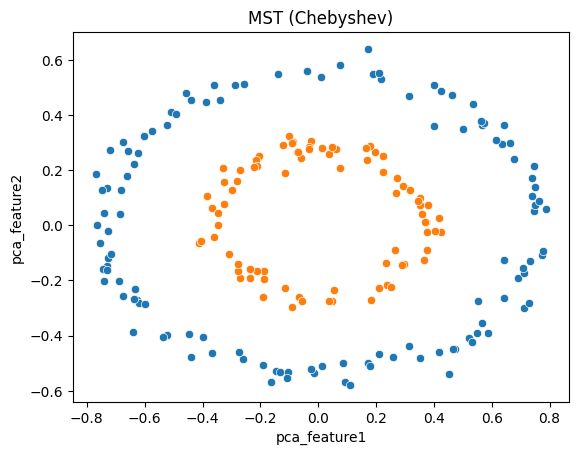

In [145]:
plt.title('MST (Chebyshev)')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_mst)):
    sns.scatterplot(x=data_2d[list(clusters_mst[i])][:, 0], y=data_2d[list(clusters_mst[i])][:, 1])

Все варианты MST выделели одинаковые кластера, совпадающие с визуально выделяющимися кольцами.

#### Кластеризация методом K-Means

Использовалась реализация этого алгоритма из библиотеки sklearn - стандартный K-Means на евклидовых расстояниях.

In [146]:
kmeans = KMeans(n_clusters=2, n_init=50)
kmeans.fit(X)
labels_kmeans = kmeans.predict(X)
cluster1 = np.arange(0, 199)[labels_kmeans == 1]
cluster2 = np.arange(0, 199)[labels_kmeans == 0]
clusters_kmeans = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_kmeans, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 92, 191, 194, 195, 196, 197, 198]
Кластер 2: [86, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193]


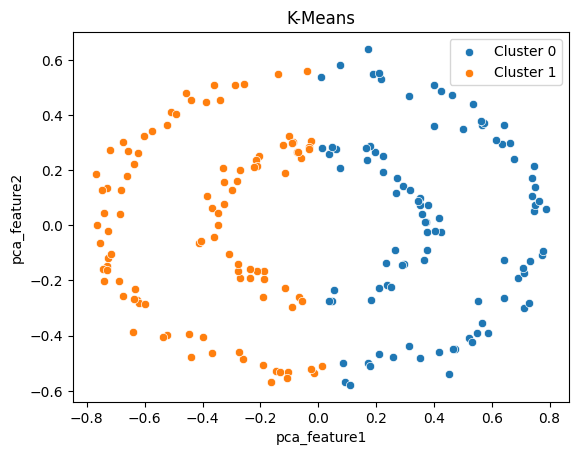

In [147]:
plt.title('K-Means')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_kmeans)):
    sns.scatterplot(x=data_2d[list(clusters_kmeans[i])][:, 0], y=data_2d[list(clusters_kmeans[i])][:, 1],
                    label=f'Cluster {i}')

Чтобы нарисовать центры, полученные алгоритмом, применим его к данным вложенным в двумерие

In [148]:
kmeans = KMeans(n_clusters=2, n_init=50)
kmeans.fit(data_2d)
labels = kmeans.predict(data_2d)
cluster1 = np.arange(0, 199)[labels == 1]
cluster2 = np.arange(0, 199)[labels == 0]
clusters_kmeans = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_kmeans, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [86, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193]
Кластер 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 92, 191, 194, 195, 196, 197, 198]


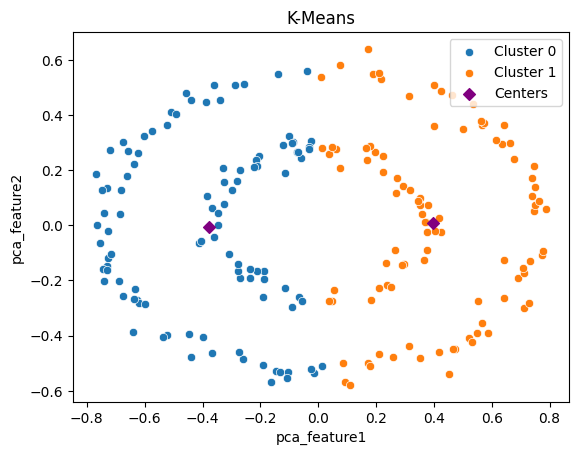

In [149]:
centroids = kmeans.cluster_centers_

plt.title('K-Means')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_kmeans)):
    sns.scatterplot(x=data_2d[list(clusters_kmeans[i])][:, 0], y=data_2d[list(clusters_kmeans[i])][:, 1],
                    label=f'Cluster {i}')
    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='D', label='Centers', color='purple')
plt.legend(loc='upper right')

#### Кластеризация EM-алгоритмом

Использовалась реализация этого алгоритма из библиотеки sklearn - Gaussian Mixture.

Алгоритм предполагает, что данные сгенерированы из смеси k нормальных распределений, имеющих свои собственные параметры. Далее алгоритм итеративно пересчитывает эти параметры, чтобы плотность смеси распределений наилучшим образом описывала данные.

In [150]:
gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=54)
gmm.fit(X)
labels_em = gmm.predict(X)
cluster1 = np.arange(0, 199)[labels_em == 1]
cluster2 = np.arange(0, 199)[labels_em == 0]
clusters_em = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_em, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 89, 92, 191, 194, 195, 196, 197, 198]
Кластер 2: [84, 86, 88, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193]


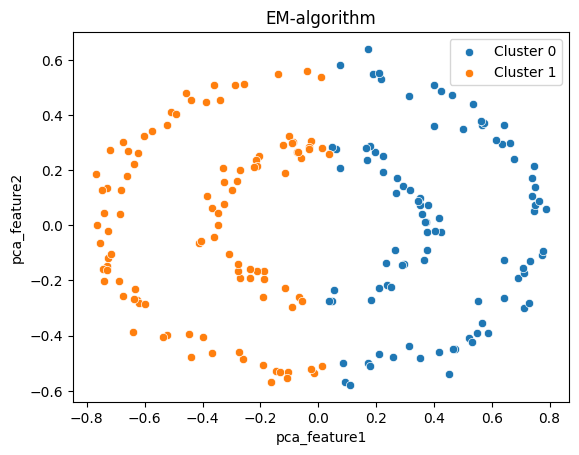

In [151]:
plt.title('EM-algorithm')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_em)):
    sns.scatterplot(x=data_2d[list(clusters_em[i])][:, 0], y=data_2d[list(clusters_em[i])][:, 1],
                    label=f'Cluster {i}')

Кластеризация EM-алгоритмом на двумерных данных для визуализации результатов

In [152]:
gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=54)
gmm.fit(data_2d)
labels = gmm.predict(data_2d)
cluster1 = np.arange(0, 199)[labels == 1]
cluster2 = np.arange(0, 199)[labels == 0]
clusters_em = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_em, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 89, 92, 191, 194, 195, 196, 197, 198]
Кластер 2: [84, 86, 88, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193]


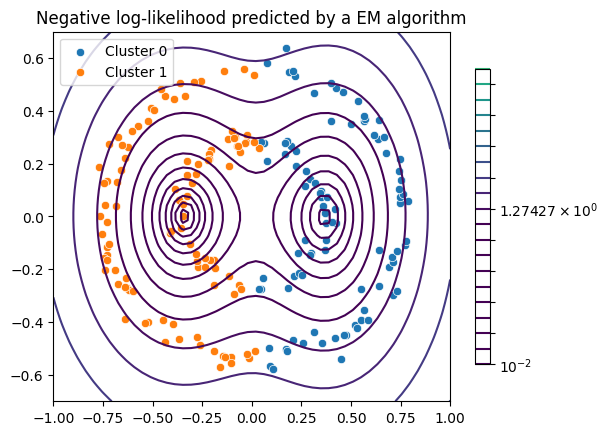

In [153]:
x = np.linspace(-1, 1)
y = np.linspace(-0.7, 0.7)
X_, Y_ = np.meshgrid(x, y)
XX = np.array([X_.ravel(), Y_.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X_.shape)

CS = plt.contour(
    X_, Y_, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(-2, 2, 20)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
# plt.scatter(data_2d[:, 0], data_2d[:, 1], 0.8)
for i in range(len(clusters_em)):
    sns.scatterplot(x=data_2d[list(clusters_em[i])][:, 0], y=data_2d[list(clusters_em[i])][:, 1],
                    label=f'Cluster {i}')

plt.title("Negative log-likelihood predicted by a EM algorithm")
plt.axis("tight")
plt.show()

Линии уровня на иллюстрации выше показывают плотность вероятности гауссовых компонент

#### Кластеризация Unnormalized Spectral методом

In [154]:
W = sim_matrix
D = np.diag([W.shape[0] for _ in range(W.shape[0])])
L = D - W

In [155]:
eig_vals, eig_vecs = np.linalg.eigh(L)
eig_vecs_2 = eig_vecs[:, :2]
kmeans = KMeans(n_clusters=2, n_init=50)
labels_spectral = kmeans.fit_predict(eig_vecs_2)
cluster1 = np.arange(0, 199)[labels_spectral == 1]
cluster2 = np.arange(0, 199)[labels_spectral == 0]
clusters_spectral = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_spectral, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 92, 191, 193, 194, 195, 196, 197, 198]
Кластер 2: [86, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192]


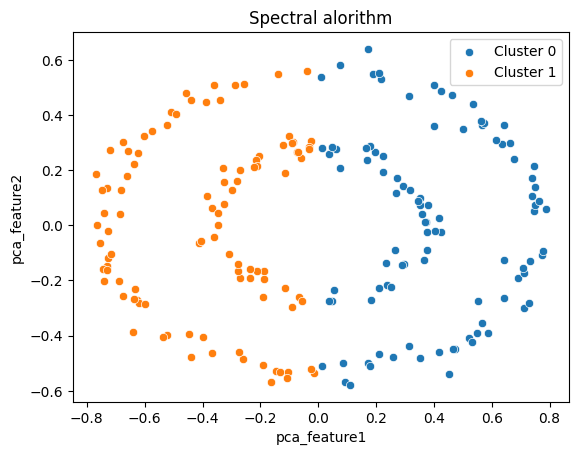

In [156]:
plt.title('Spectral alorithm')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_spectral)):
    sns.scatterplot(x=data_2d[list(clusters_spectral[i])][:, 0], y=data_2d[list(clusters_spectral[i])][:, 1],
                    label=f'Cluster {i}')

#### Подсчет RAND индекса

Сравнение разбиений попарно

In [157]:
def count_pairs_disjoin(left_set: set, right_sets: list):
    left_set_pairs_cnt = len(left_set) * (len(left_set) - 1)

    for rs in right_sets:
        separation = left_set.intersection(rs)
        left_set_pairs_cnt = left_set_pairs_cnt - len(separation) * (
            len(separation) - 1
        )

    return left_set_pairs_cnt


def count_pairs_join(left_set: set, right_sets: list):
    left_set_pairs_cnt = 0

    for rs in right_sets:
        separation = left_set.intersection(rs)
        left_set_pairs_cnt = left_set_pairs_cnt + len(separation) * (
            len(separation) - 1
        )

    return left_set_pairs_cnt


def get_rand_index(part1: list, part2: list):
    left_sets = part1
    right_sets = part2

    left_pair_union = sum([count_pairs_join(x, right_sets) for x in left_sets])
    right_pair_union = sum([count_pairs_join(x, left_sets) for x in right_sets])

    union_cnt = left_pair_union + right_pair_union

    left_pair_diff = sum([count_pairs_disjoin(x, right_sets) for x in left_sets])
    right_pair_diff = sum([count_pairs_disjoin(x, left_sets) for x in right_sets])

    diff_cnt = left_pair_diff + right_pair_diff

    return union_cnt / (union_cnt + diff_cnt)

In [158]:
def r_partition(n_parts, edges):
    idxs = list(range(0, edges))
    random.shuffle(idxs)
    return [set(idxs[i::n_parts]) for i in range(n_parts)]

In [159]:
rand_idx_matrix = np.zeros((5, 5))

for i, m1 in enumerate([clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]):
    for j, m2 in enumerate(
        [clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]
    ):
        rand_idx_matrix[i, j] = get_rand_index(m1, m2)

rand_idx_matrix

array([[1.        , 0.5037594 , 0.50445579, 0.50376015, 0.        ],
       [0.5037594 , 1.        , 0.97005805, 0.98990311, 0.        ],
       [0.50445579, 0.97005805, 1.        , 0.960273  , 0.        ],
       [0.50376015, 0.98990311, 0.960273  , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [160]:
random_partitions = [r_partition(2, 199) for i in range(100)]

In [161]:
for i, m in enumerate([clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]):
    mean_rand_idx_vs_randompart = (
        sum([get_rand_index(m, r) for r in random_partitions]) / 100
    )
    rand_idx_matrix[i, 4] = rand_idx_matrix[4, i] = mean_rand_idx_vs_randompart

In [162]:
rand_idx_matrix[4, 4] = sum([sum([get_rand_index(r1, r2) for r1 in random_partitions]) for r2 in random_partitions]) / 100**2

In [163]:
rand_idx_matrix

array([[1.        , 0.5037594 , 0.50445579, 0.50376015, 0.50605295],
       [0.5037594 , 1.        , 0.97005805, 0.98990311, 0.49777336],
       [0.50445579, 0.97005805, 1.        , 0.960273  , 0.49811736],
       [0.50376015, 0.98990311, 0.960273  , 1.        , 0.49752193],
       [0.50605295, 0.49777336, 0.49811736, 0.49752193, 0.502562  ]])

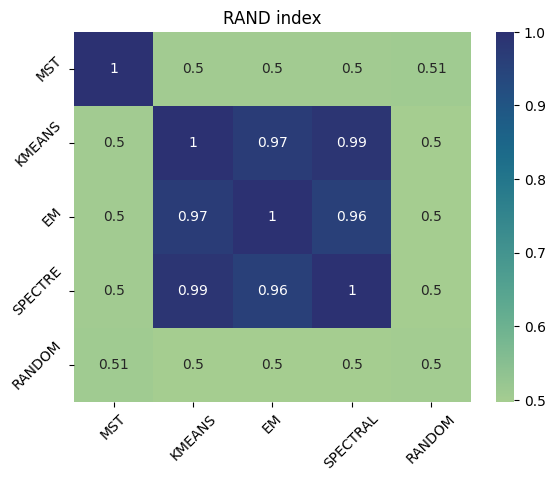

In [164]:
plt.title("RAND index")
g = sns.heatmap(
    rand_idx_matrix,
    annot=True,
    xticklabels=["MST", "KMEANS", "EM", "SPECTRAL", "RANDOM"],
    yticklabels=["MST", "KMEANS", "EM", "SPECTRE", "RANDOM"],
    cmap="crest",
)
if g.get_yticklabels():
    g.set_yticklabels(labels=g.get_yticklabels(), rotation=45)
if g.get_xticklabels():
    g.set_xticklabels(g.get_xticklabels(), rotation=45)

Значения RAND индексов говорят о том, что алгоритьмы EM, K-Means и Spectral получают очень похожие между собой разбиения, отличные от разбиений полученных MST и случайными алгоритмами. В то же время, MST получает разбиения, не похожие ни на вышеупомянутые алгоритмы, ни на случайный алгоритм.
Это также подтверждается двумерными картами полученных разбиений: по ним видно, что EM, K-Means и Spectral получают одинаковые разбиения, а MST-алгоритм получает абсолютно другое разбиение.

Под рандомным алгоритмом здесь имеется в виду следующее:
1) Было сделано 100 случайных разбиений графа
2) Для каждого такого разбиения считался RAND индекс с каждым разбиением, полученным другим методом, после чего значения были усреднены.
3) Чтобы получить RAND индекс пары (случайный алгоритм, случайный алгоритм), были посчитаны RAND индексы между всеми случайными разбиениями и затем усреднены.

In [165]:
mfn_rand = []

for k in range(0, 100):
    rpart = r_partition(2, 199)
    mfn_rand.append(nx.community.modularity(G, rpart))

In [166]:
for part, part_name in zip(
    [clusters_mst, clusters_kmeans, clusters_em, clusters_spectral],
    ["MST", "KMEANS", "EM", "SPECTRAL"],
):
    print(f"{part_name} clustering modularity value:", nx.community.modularity(G, part))
print("RANDOM clustering modularity value:", sum(mfn_rand) / 100)

MST clustering modularity value: 0.009758673215768288
KMEANS clustering modularity value: 0.038859366448299154
EM clustering modularity value: 0.03866987484232534
SPECTRAL clustering modularity value: 0.03879971327646051
RANDOM clustering modularity value: -0.0025910708680158996


Примечание: можно заметить, что средние значения RAND индекса между любыми методами и случайным, как и случайного с собой примерно равно 1/(количество кластеров) ~= 0.5; что, вероятно, позволяет воспринимать такое значение как некое калибровочное или базовое.

Значения модулярности для разбиений, полученных вышеописанными алгоритмами получились довольно маленькими, но все же относительно сильно больше, чем для случайных разбиений. Из этого можно предположить, что алгоритмы кластеризовали данные  лучше чем случайная кластеризация.

Также видно, что значения функции модулярности у EM, K-Means и Spectral алгоритмов почти равны, что вкупе с индексами RAND и двумерными картами для этих пар говорит о том, что эти алгоритмы получают очень похожие разбиения. MST алгоритм же получает совсем другие разбиения, и значение функции модулярности для него в несколько раз меньше, чем для других алгоритмов, что может говорить о том, что вершины в кластерах, полученных этим алгоритмом, слабее связаны в контексте полученной нами матрицы similarity.

В то же время, визуальный анализ показывает, что именно MST правильно разбил данные на 2 кластера.

In [167]:
def get_labels_from_clusters(clusters):
    labels = np.zeros(sum([len(c) for c in clusters]), dtype=int)
    for i, cluster in enumerate(clusters):
        labels[list(cluster)] = i
    return labels

In [168]:
sil_rand = []

for k in range(0, 100):
    rpart = r_partition(2, 199)
    sil_rand.append(silhouette_score(X, get_labels_from_clusters(rpart)))

#### Подсчет Silhouette Score

Silhouette score отражает близость каждого наблюдения к точкам из своего кластера и других кластеров. Данная метрика задается следующим образом:

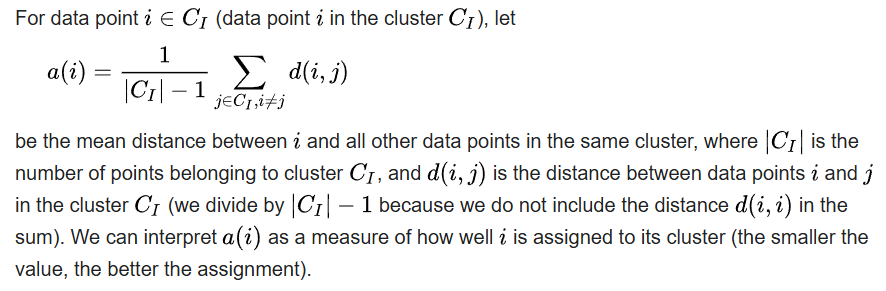
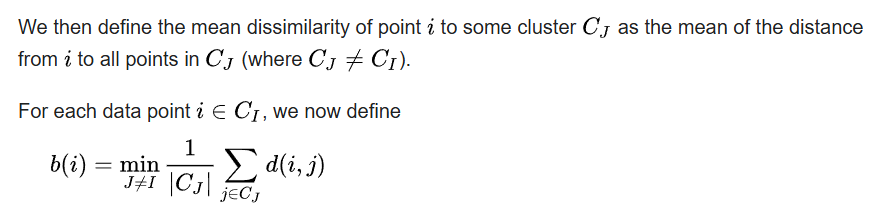
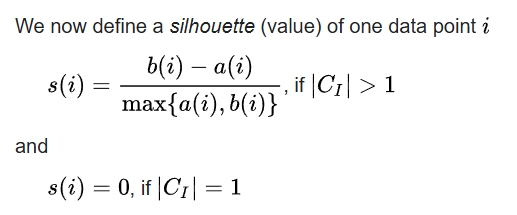

In [169]:
for part, part_name in zip(
    [clusters_mst, clusters_kmeans, clusters_em, clusters_spectral],
    ["MST", "KMEANS", "EM", "SPECTRAL"],
):
    cur_labels = get_labels_from_clusters(part)
    print(f'{part_name} silhouette score: {silhouette_score(X, cur_labels)}')
    
print("RANDOM silhouette score:", sum(sil_rand) / 100)

MST silhouette score: 0.06764033477920667
KMEANS silhouette score: 0.41765239906467655
EM silhouette score: 0.41800095023507605
SPECTRAL silhouette score: 0.4175053862958213
RANDOM silhouette score: 0.0006636234426738566


Все методы, кроме MST показывают примерно одинаковые значения метрики (выше чем MST), однако в формуле подсчета Silhouette score используется матрица расстояний, которая плохо отражает топологию данных в данном случае.

## Кластеризация для числа кластеров k=3

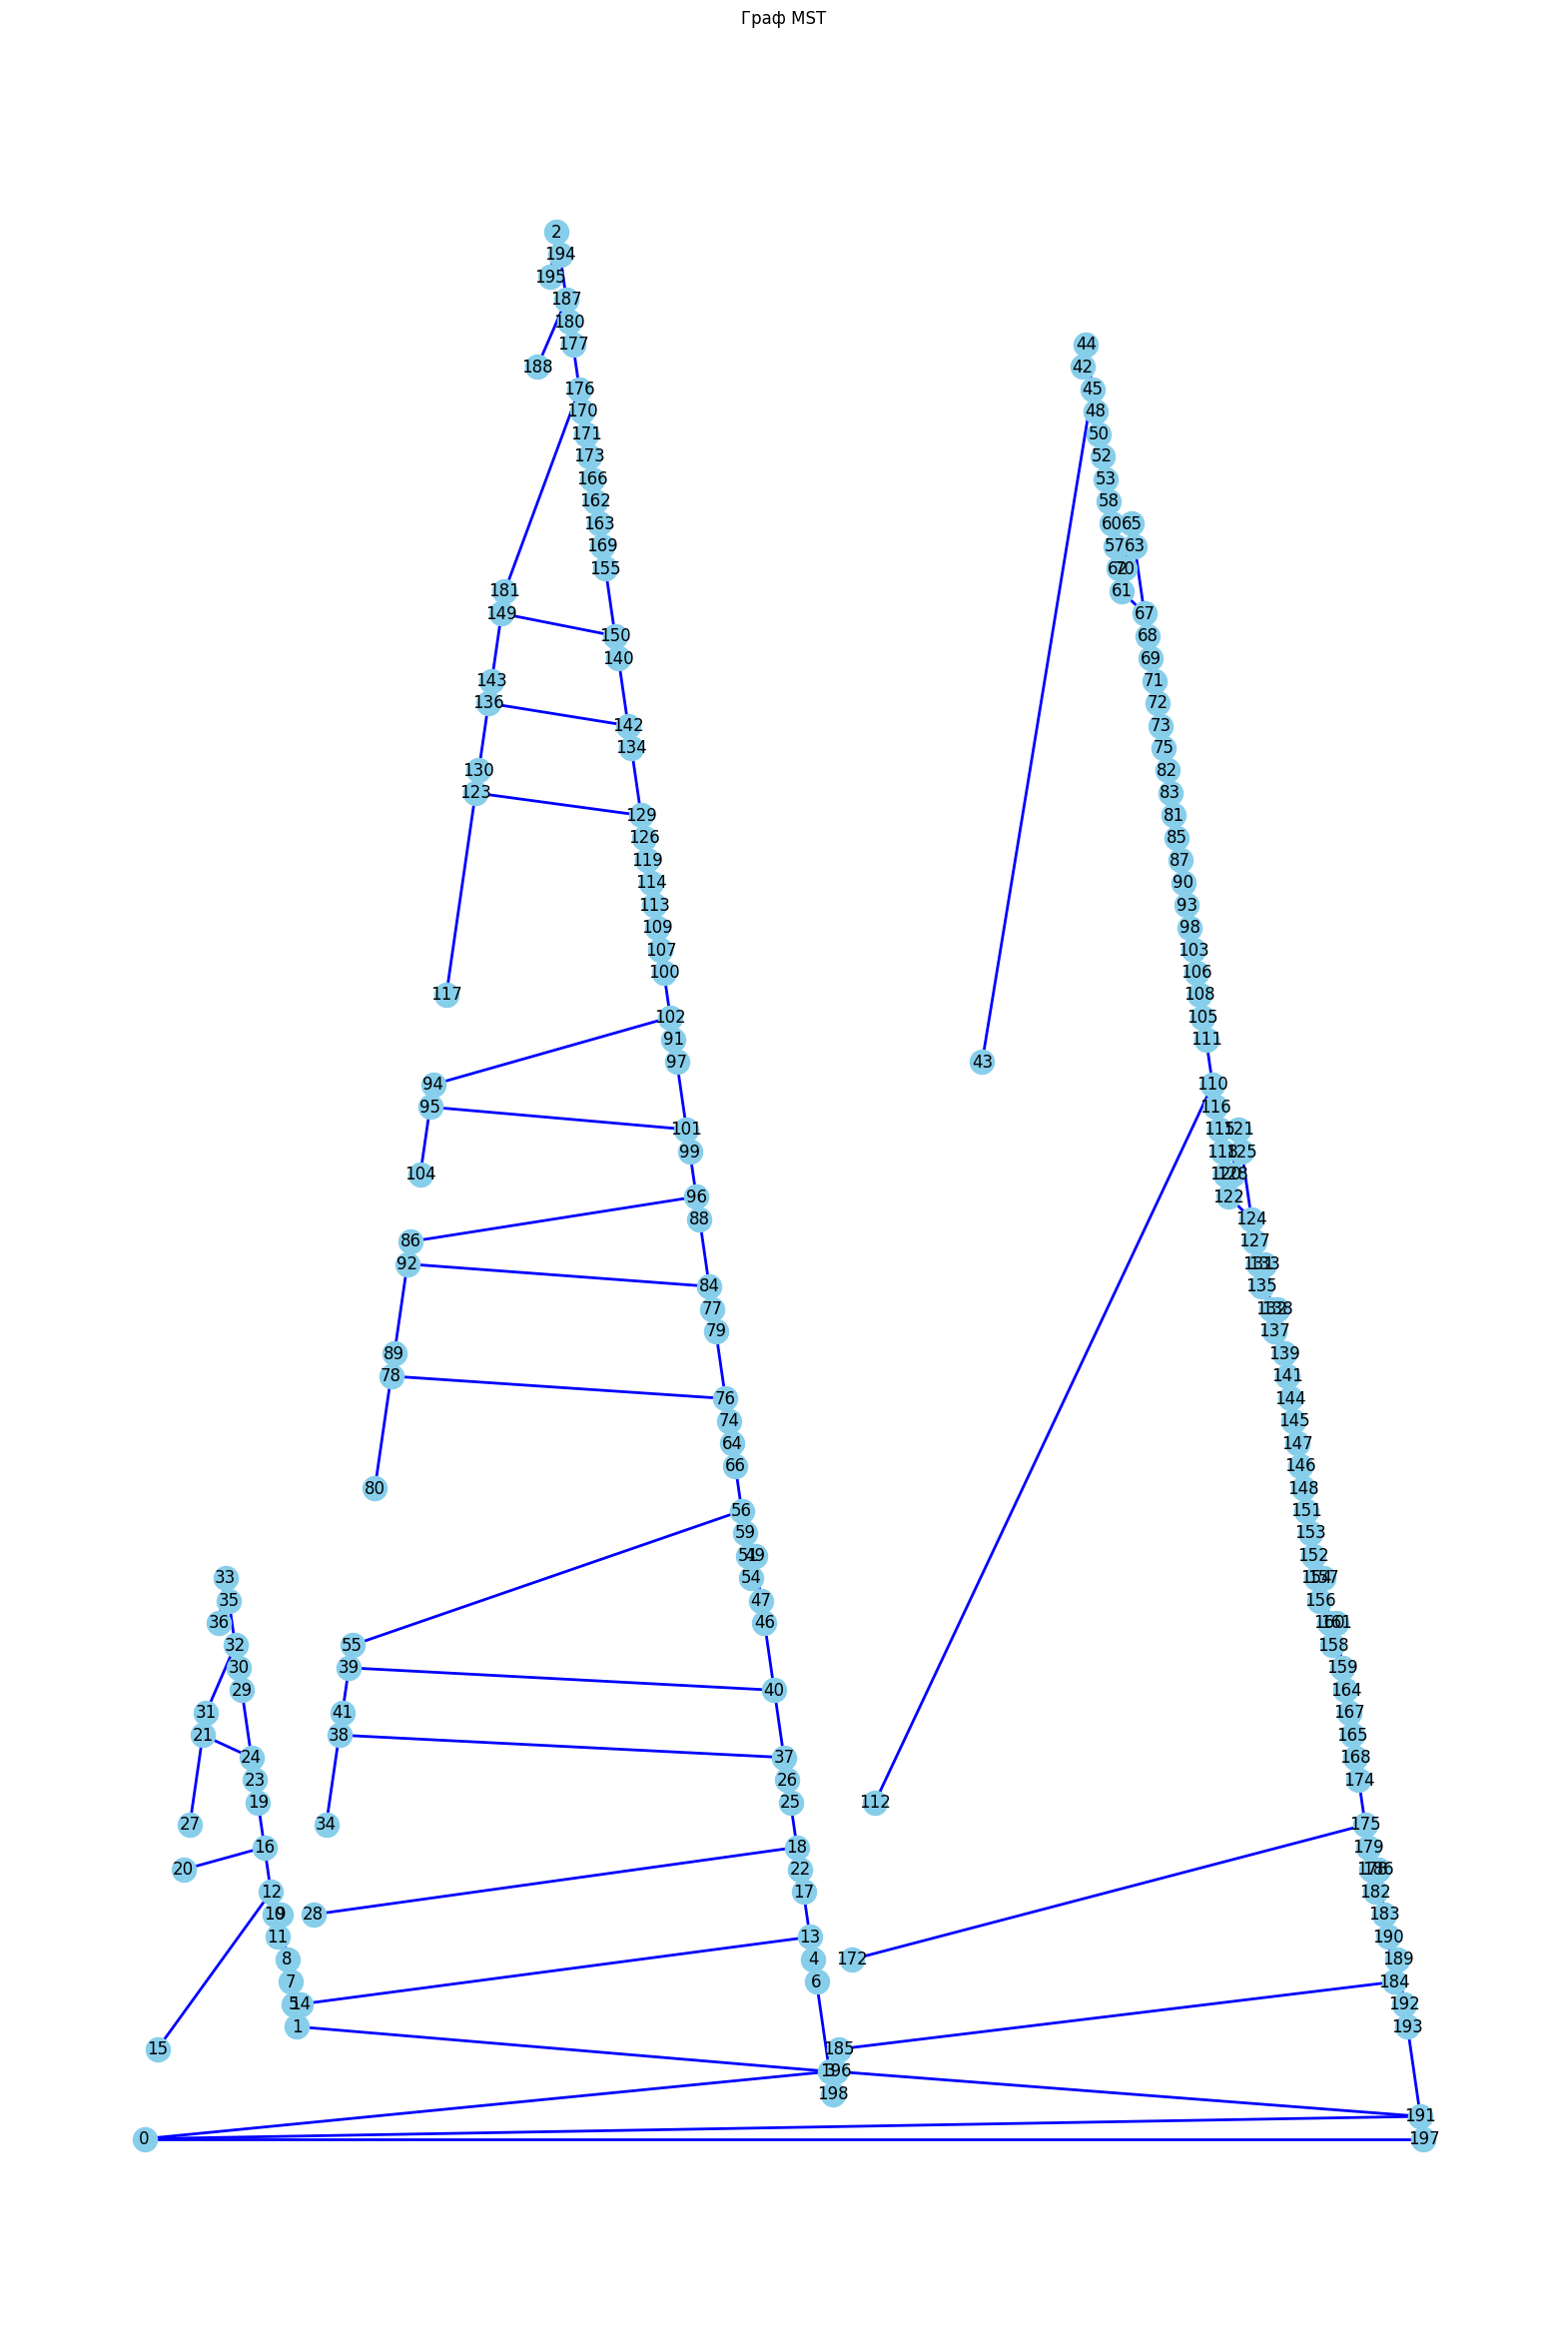

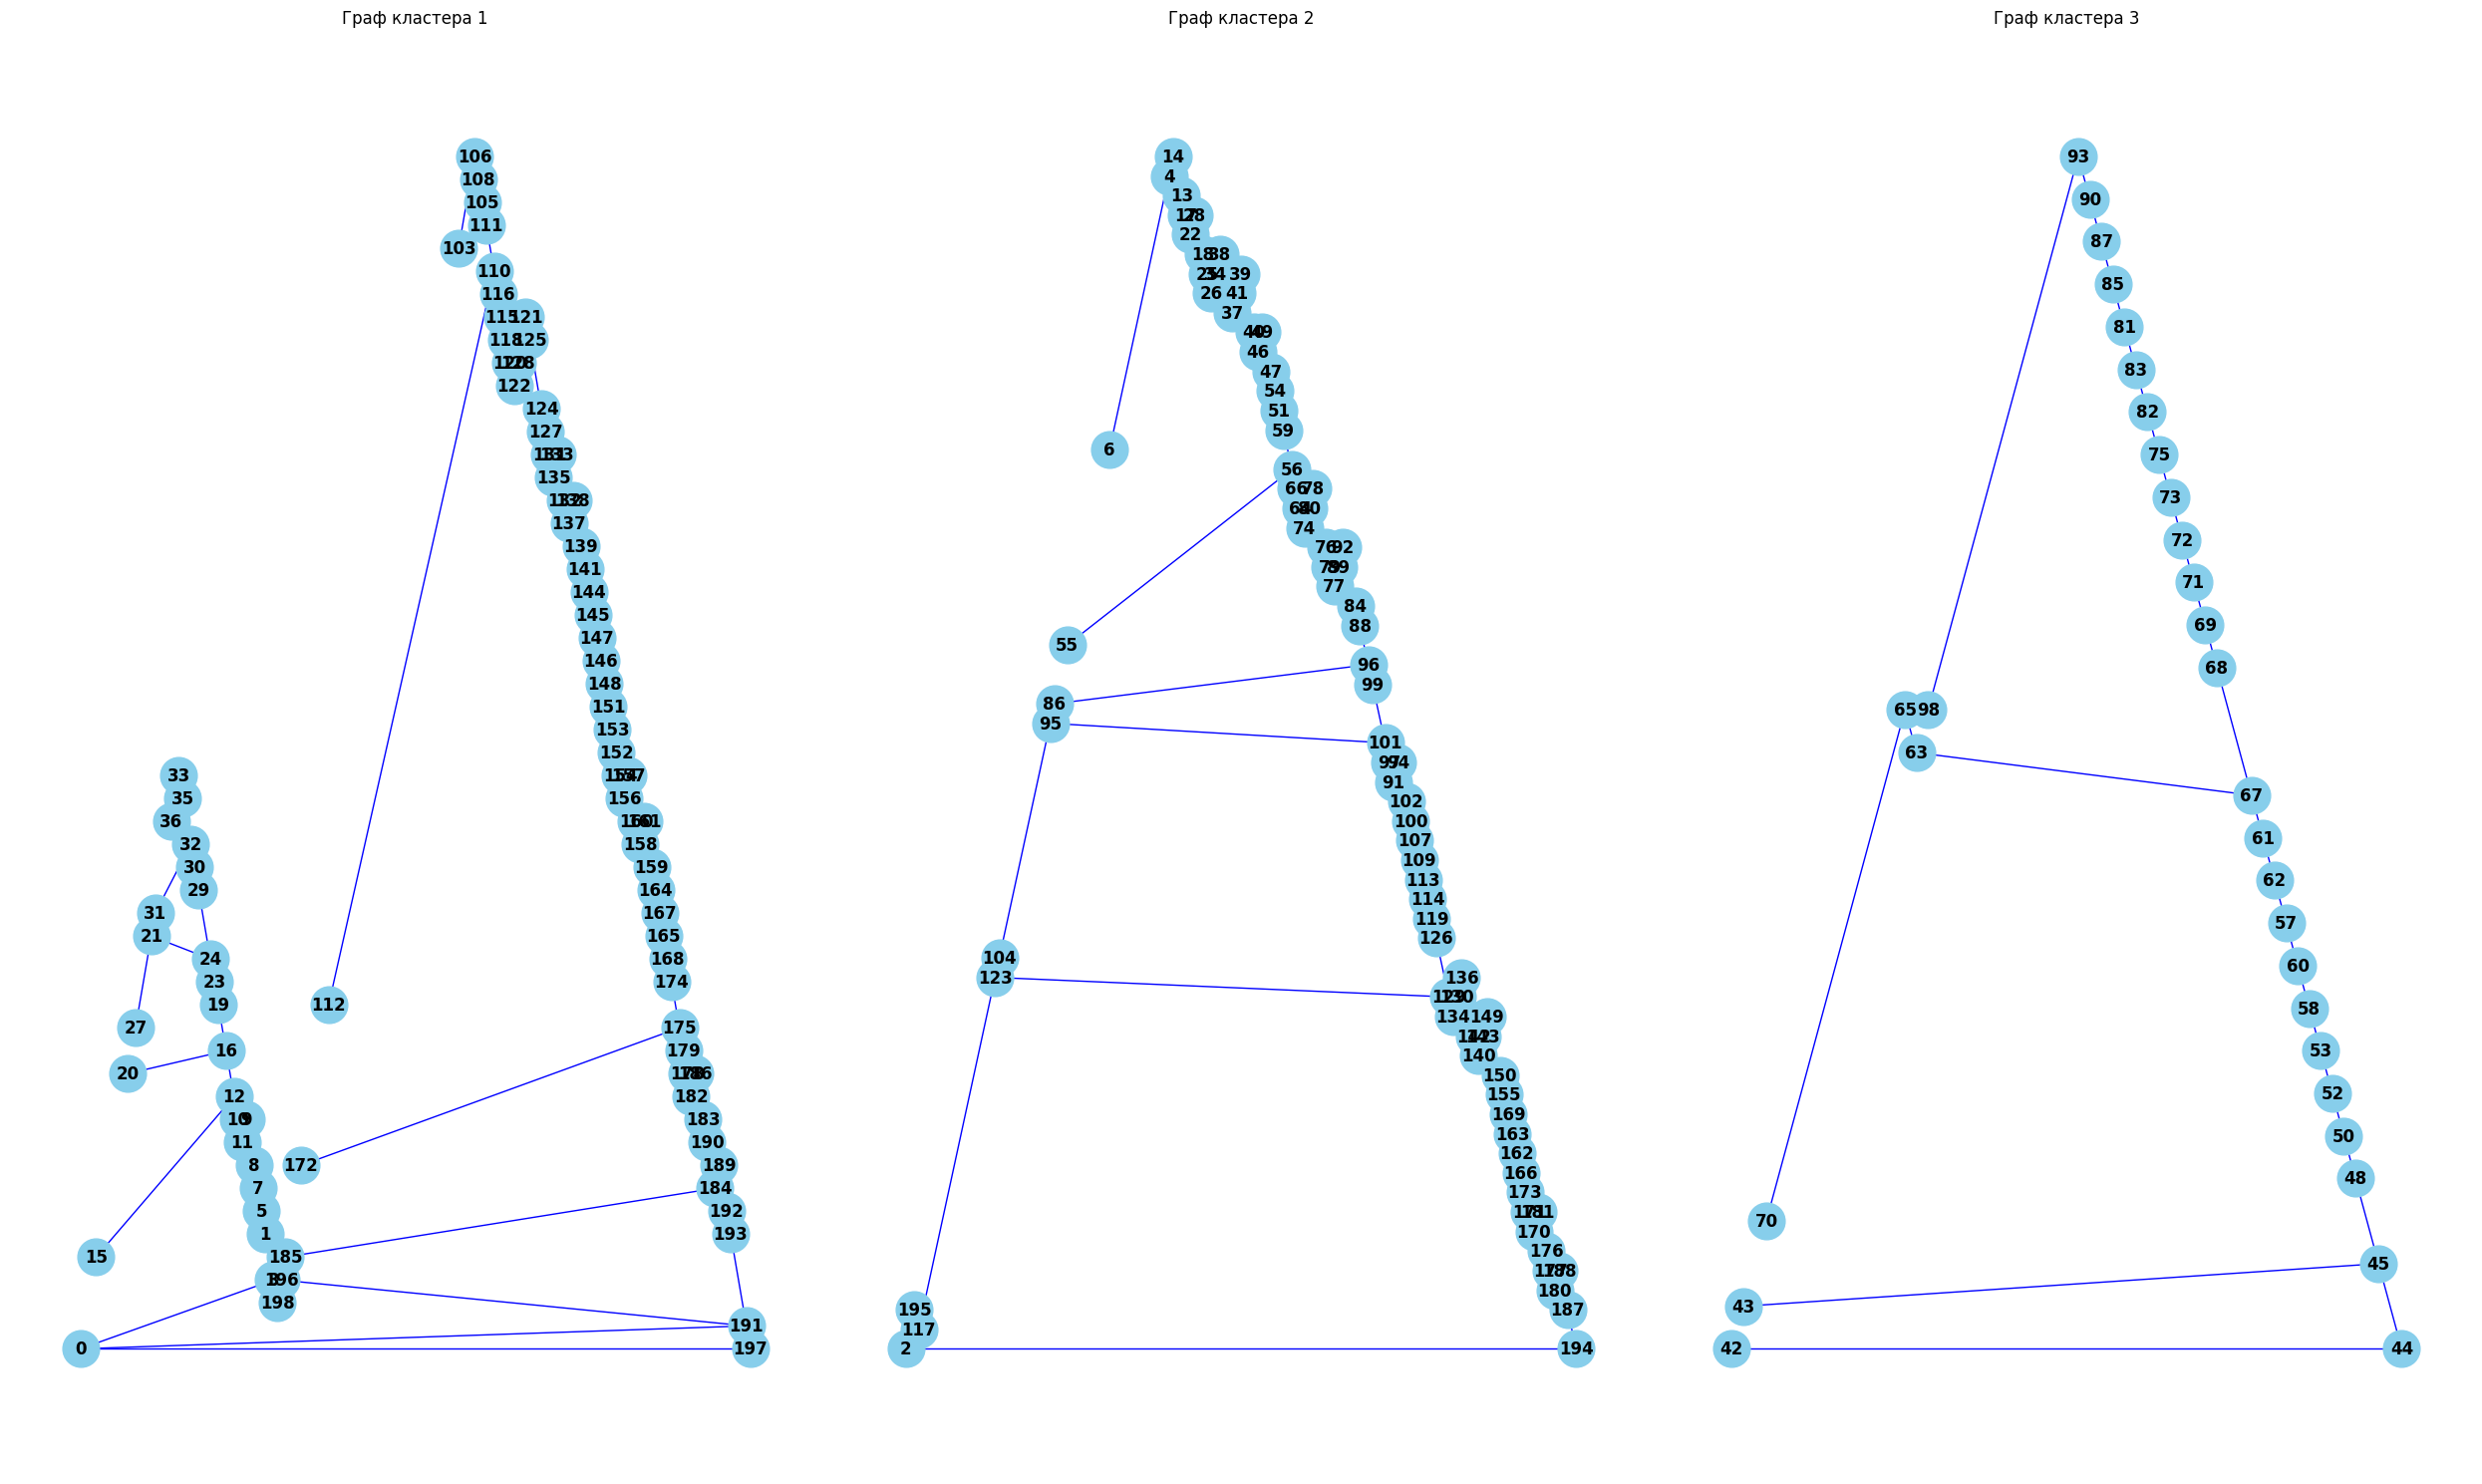

Кластер 1: [0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 19, 20, 21, 23, 24, 27, 29, 30, 31, 32, 33, 35, 36, 103, 105, 106, 108, 110, 111, 112, 115, 116, 118, 120, 121, 122, 124, 125, 127, 128, 131, 132, 133, 135, 137, 138, 139, 141, 144, 145, 146, 147, 148, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 164, 165, 167, 168, 172, 174, 175, 178, 179, 182, 183, 184, 185, 186, 189, 190, 191, 192, 193, 196, 197, 198]
Кластер 2: [2, 4, 6, 13, 14, 17, 18, 22, 25, 26, 28, 34, 37, 38, 39, 40, 41, 46, 47, 49, 51, 54, 55, 56, 59, 64, 66, 74, 76, 77, 78, 79, 80, 84, 86, 88, 89, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 104, 107, 109, 113, 114, 117, 119, 123, 126, 129, 130, 134, 136, 140, 142, 143, 149, 150, 155, 162, 163, 166, 169, 170, 171, 173, 176, 177, 180, 181, 187, 188, 194, 195]
Кластер 3: [42, 43, 44, 45, 48, 50, 52, 53, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 75, 81, 82, 83, 85, 87, 90, 93, 98]


In [209]:
G_euc, clusters_mst_euc = MST_clustering(3, sim_matrix)

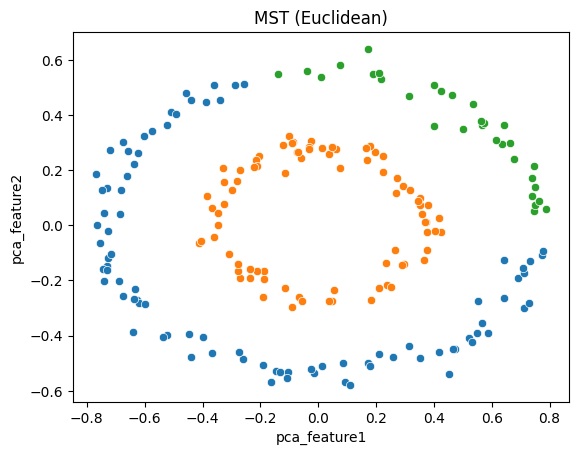

In [211]:
plt.title('MST (Euclidean)')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_mst_euc)):
    sns.scatterplot(x=data_2d[list(clusters_mst_euc[i])][:, 0], y=data_2d[list(clusters_mst_euc[i])][:, 1])

Кластеризация с использованием матрицы схожестей на основе матрицы расстояний Минковского (p=4)

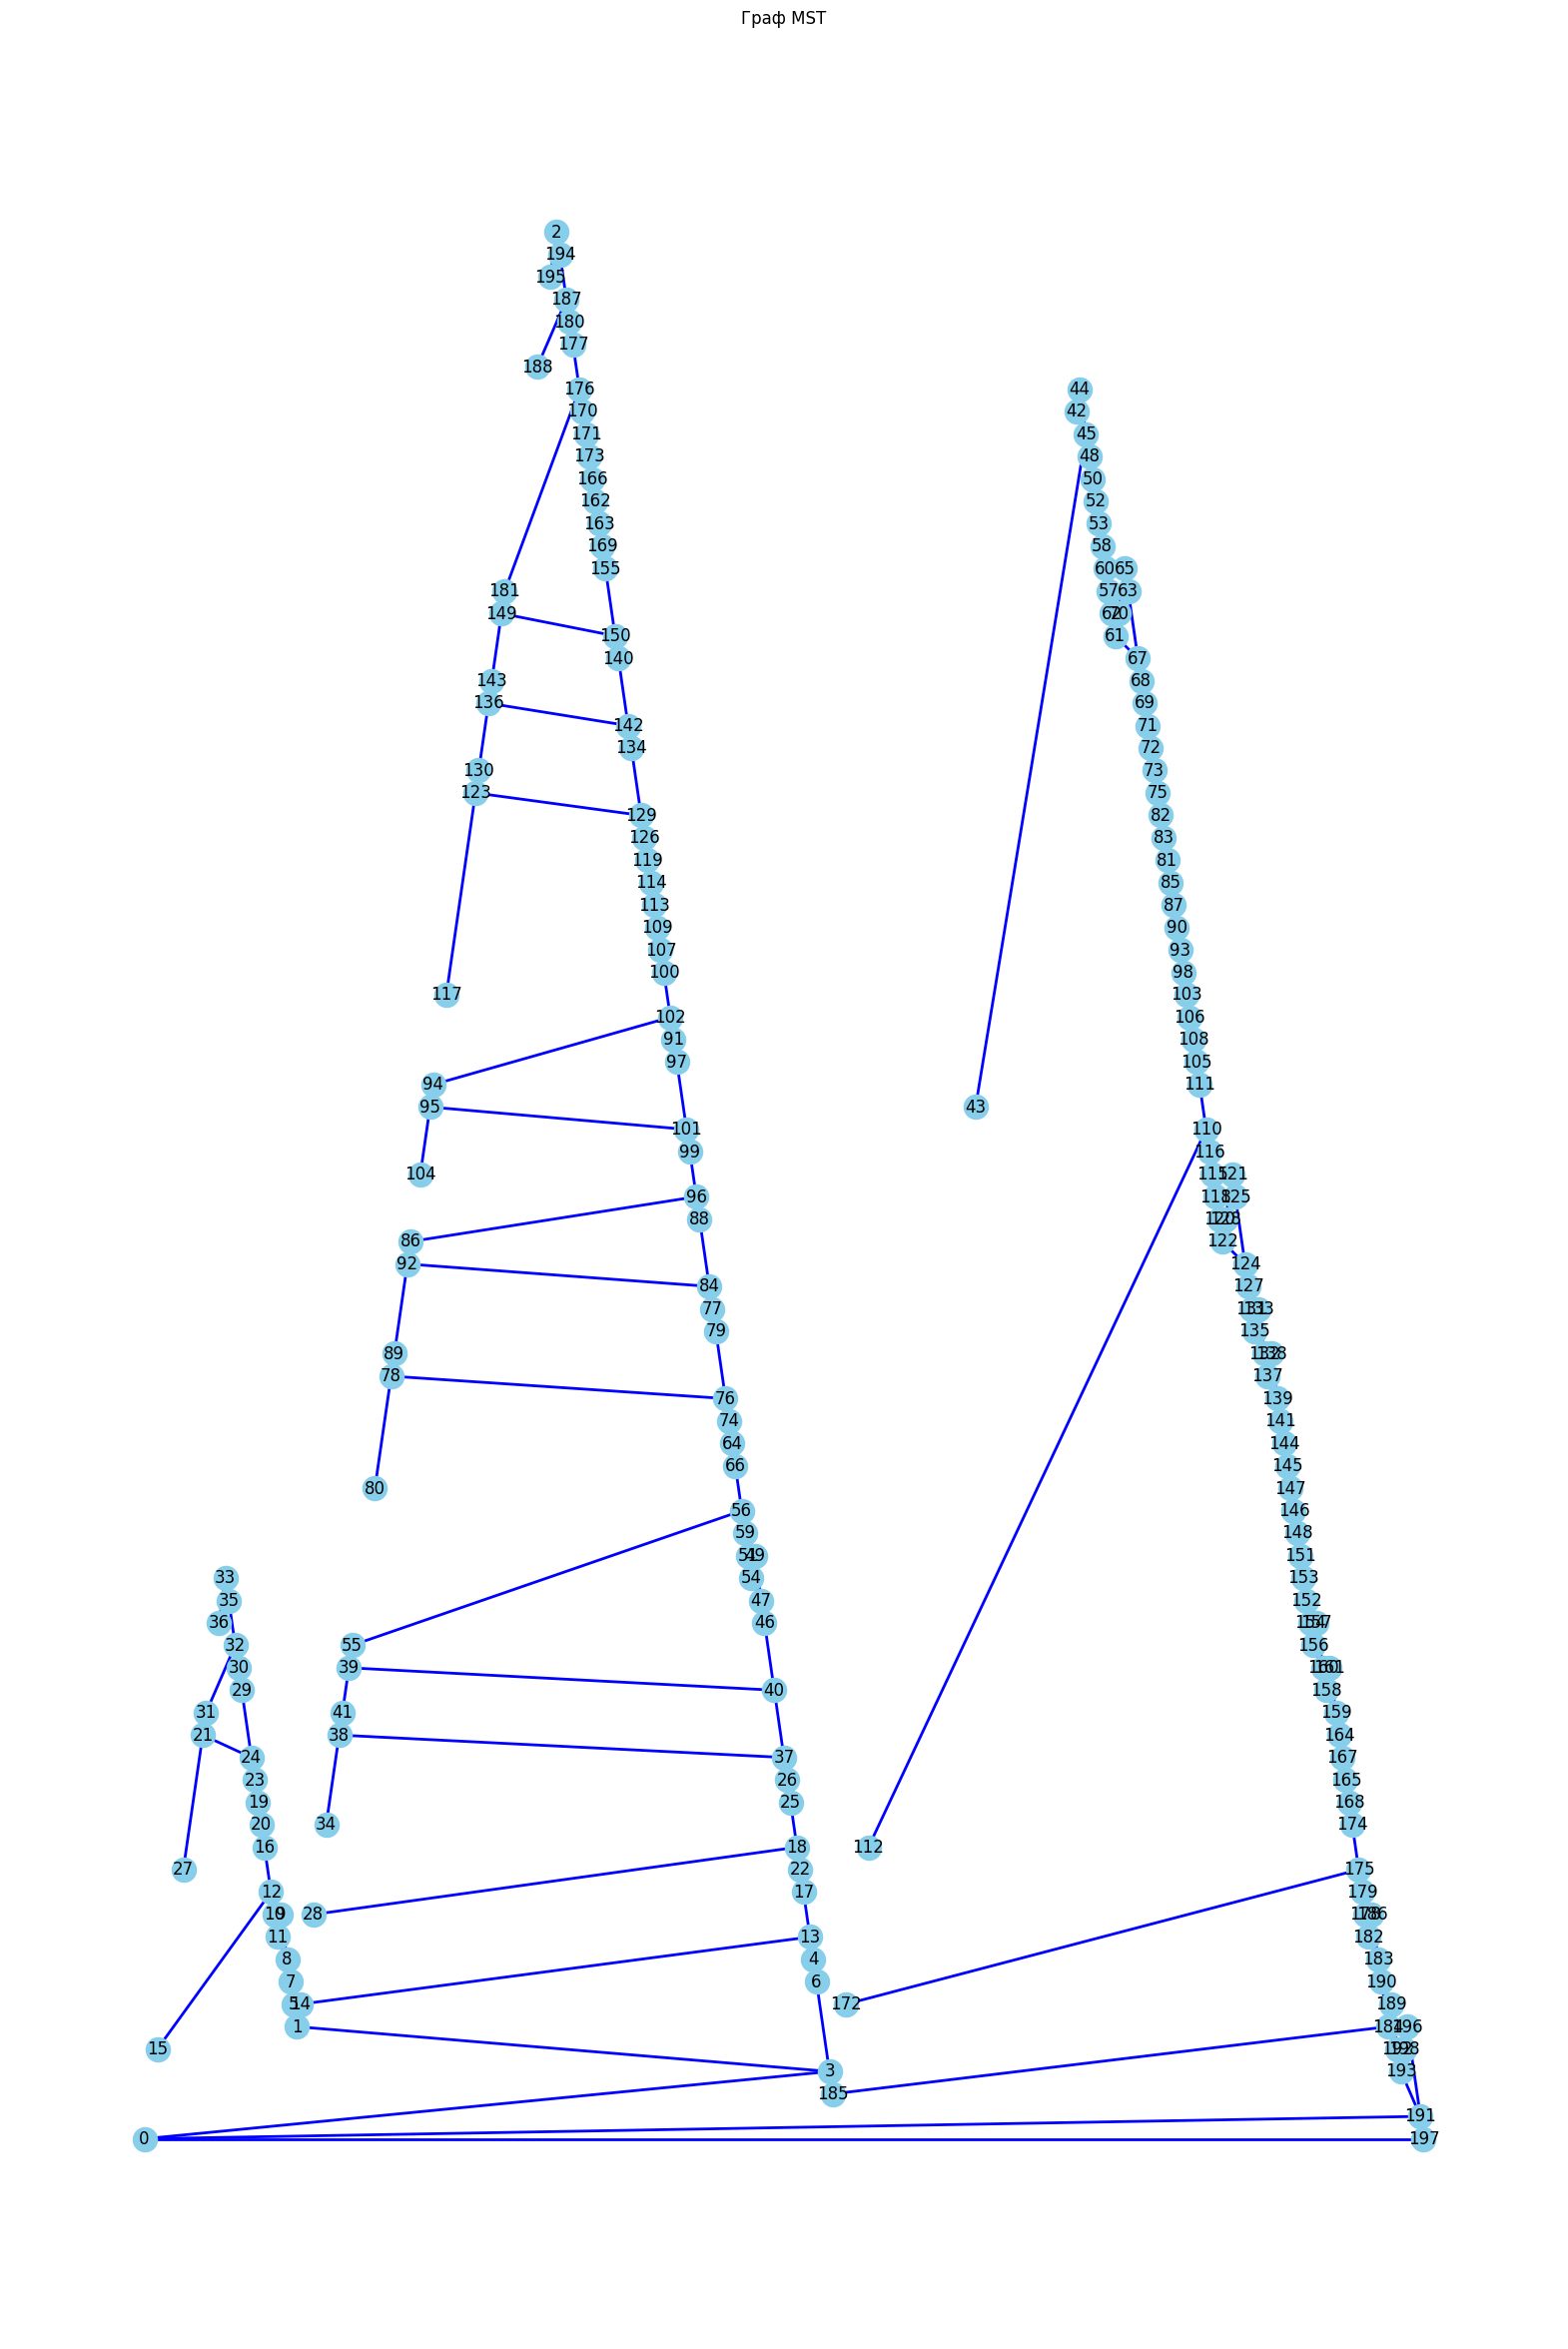

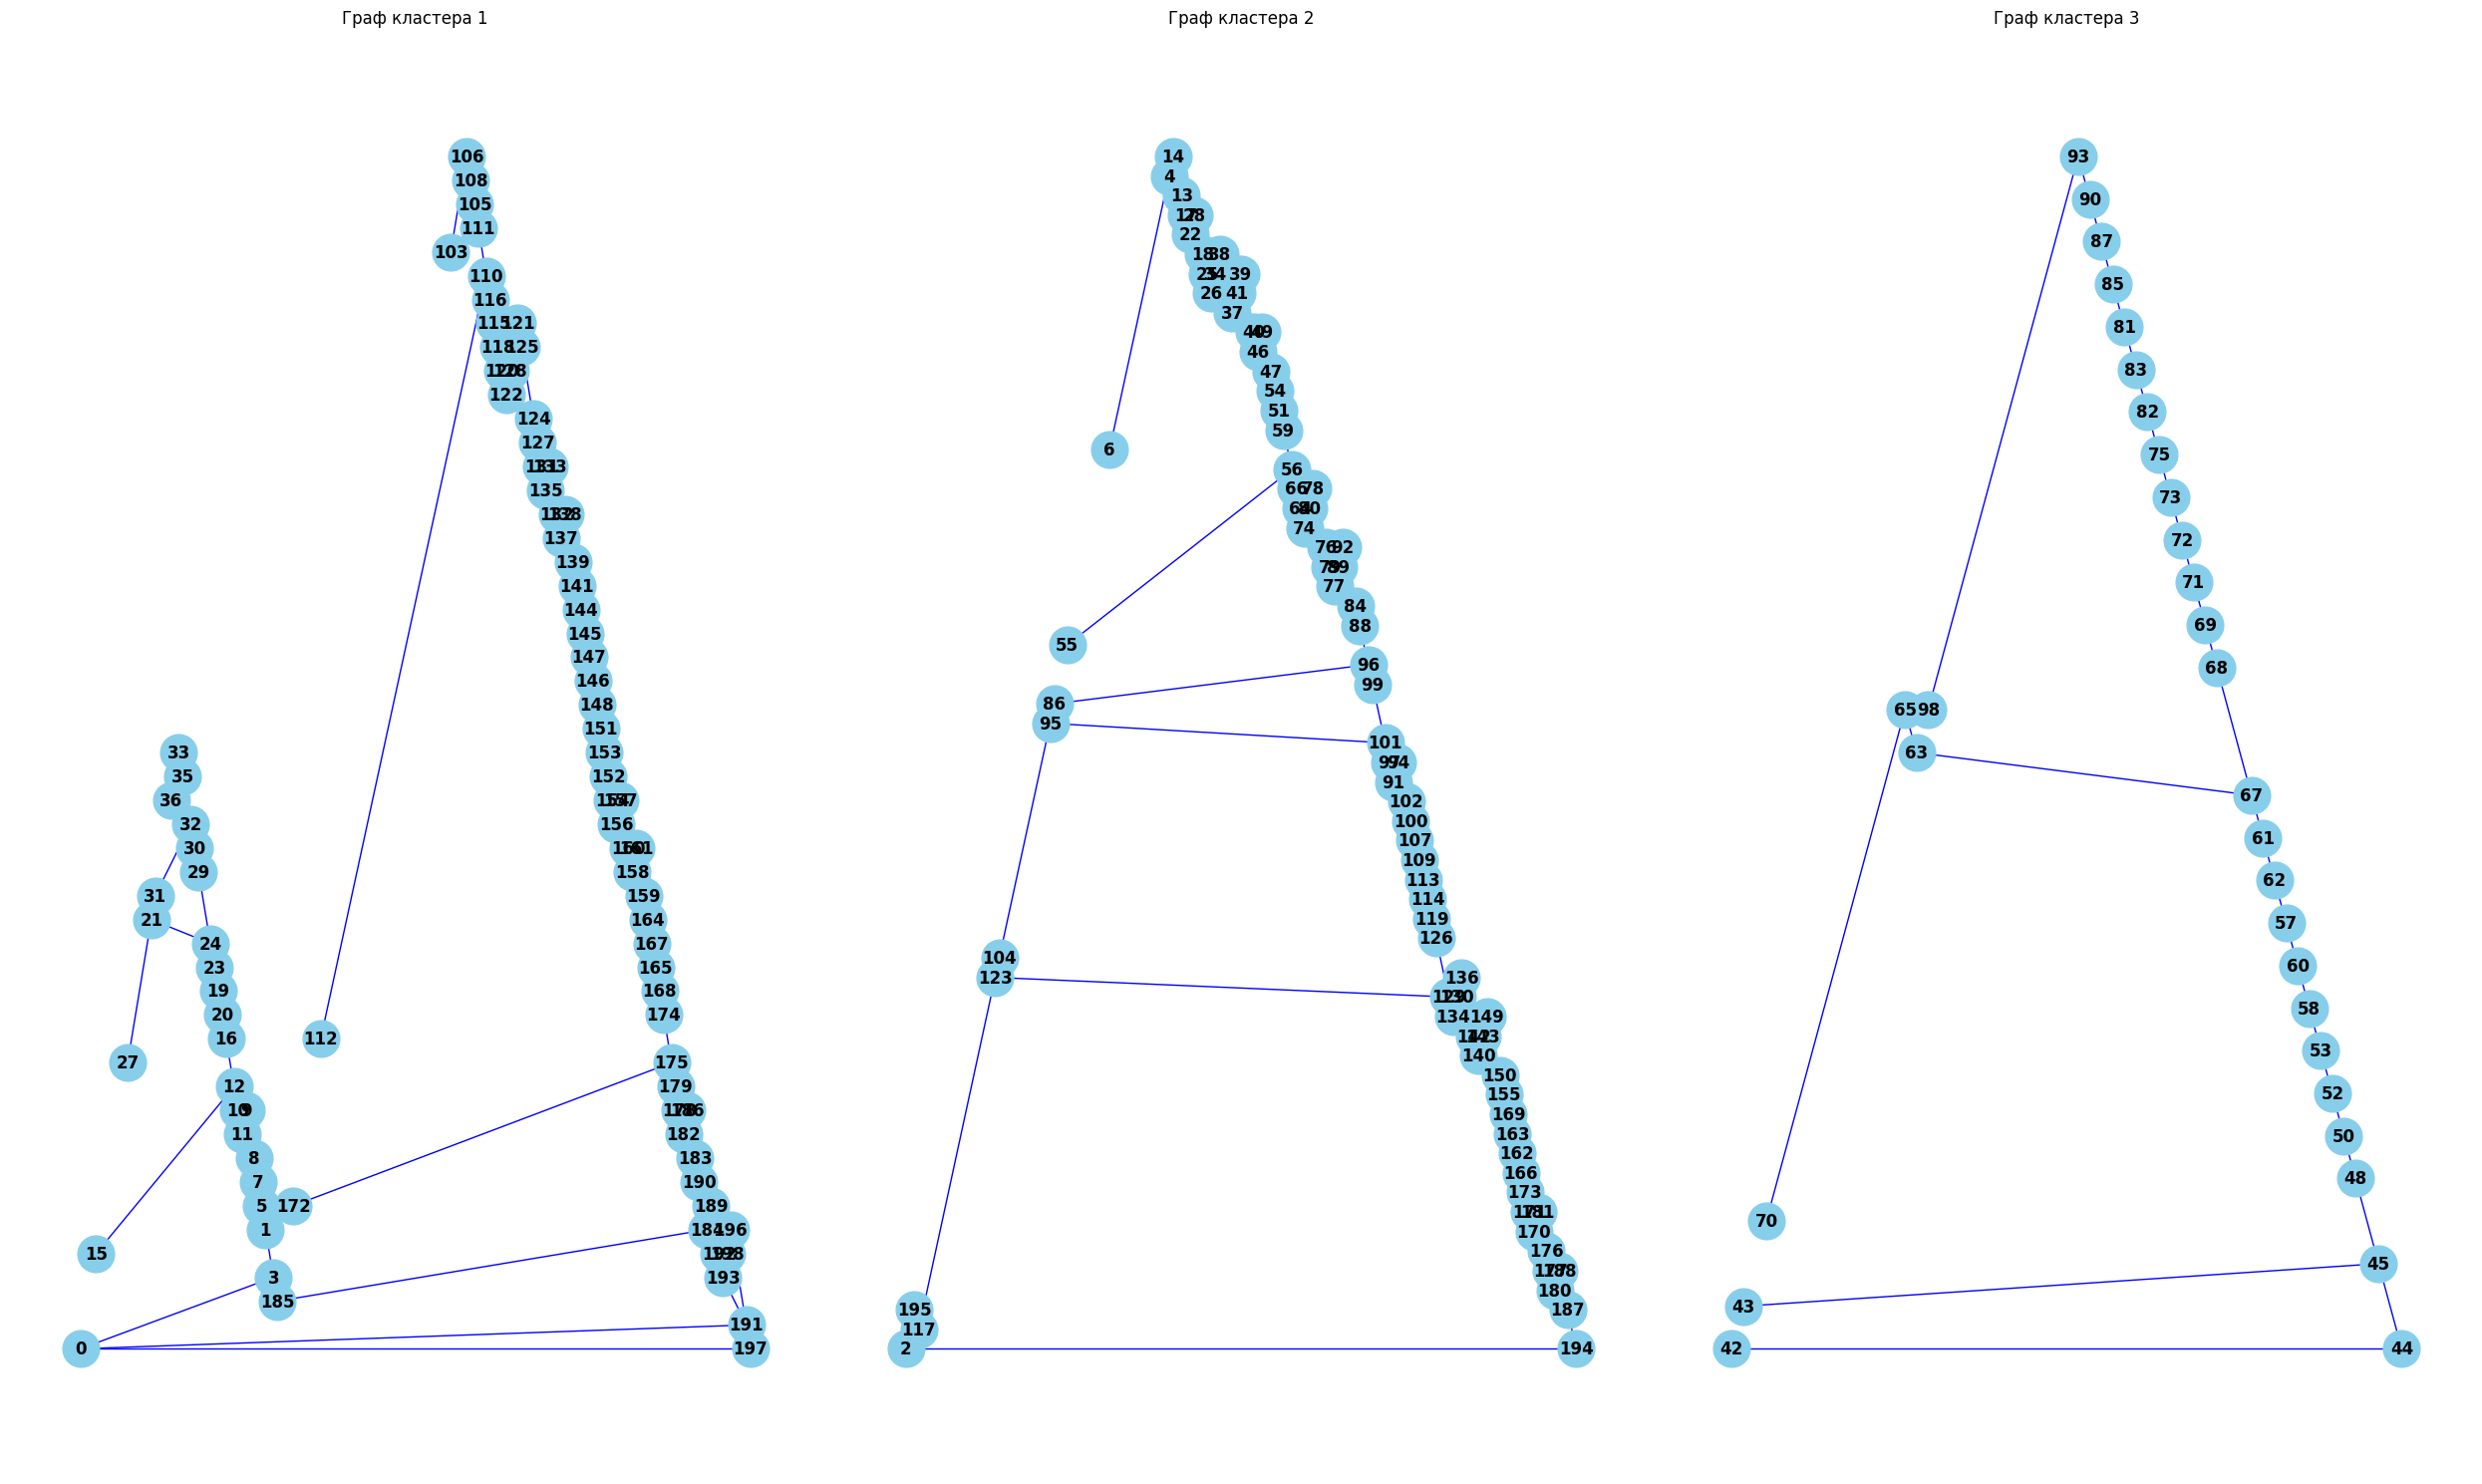

Кластер 1: [0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 19, 20, 21, 23, 24, 27, 29, 30, 31, 32, 33, 35, 36, 103, 105, 106, 108, 110, 111, 112, 115, 116, 118, 120, 121, 122, 124, 125, 127, 128, 131, 132, 133, 135, 137, 138, 139, 141, 144, 145, 146, 147, 148, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 164, 165, 167, 168, 172, 174, 175, 178, 179, 182, 183, 184, 185, 186, 189, 190, 191, 192, 193, 196, 197, 198]
Кластер 2: [2, 4, 6, 13, 14, 17, 18, 22, 25, 26, 28, 34, 37, 38, 39, 40, 41, 46, 47, 49, 51, 54, 55, 56, 59, 64, 66, 74, 76, 77, 78, 79, 80, 84, 86, 88, 89, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 104, 107, 109, 113, 114, 117, 119, 123, 126, 129, 130, 134, 136, 140, 142, 143, 149, 150, 155, 162, 163, 166, 169, 170, 171, 173, 176, 177, 180, 181, 187, 188, 194, 195]
Кластер 3: [42, 43, 44, 45, 48, 50, 52, 53, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 75, 81, 82, 83, 85, 87, 90, 93, 98]


In [205]:
G_p4, clusters_mst_p4 = MST_clustering(3, sim_matrix_minkowski)

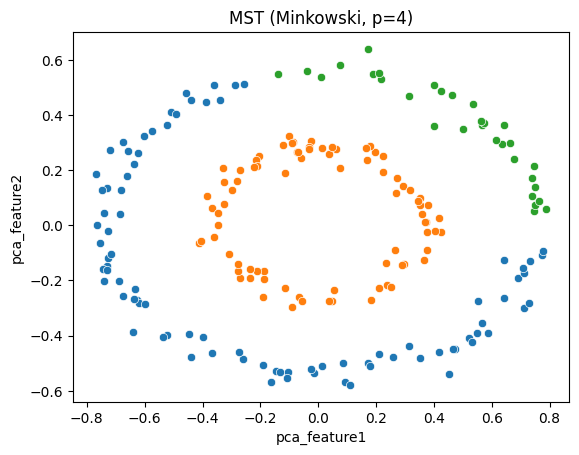

In [212]:
plt.title('MST (Minkowski, p=4)')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_mst_p4)):
    sns.scatterplot(x=data_2d[list(clusters_mst_p4[i])][:, 0], y=data_2d[list(clusters_mst_p4[i])][:, 1])

Кластеризация с использованием матрицы схожестей на основе матрицы расстояний Чебышева

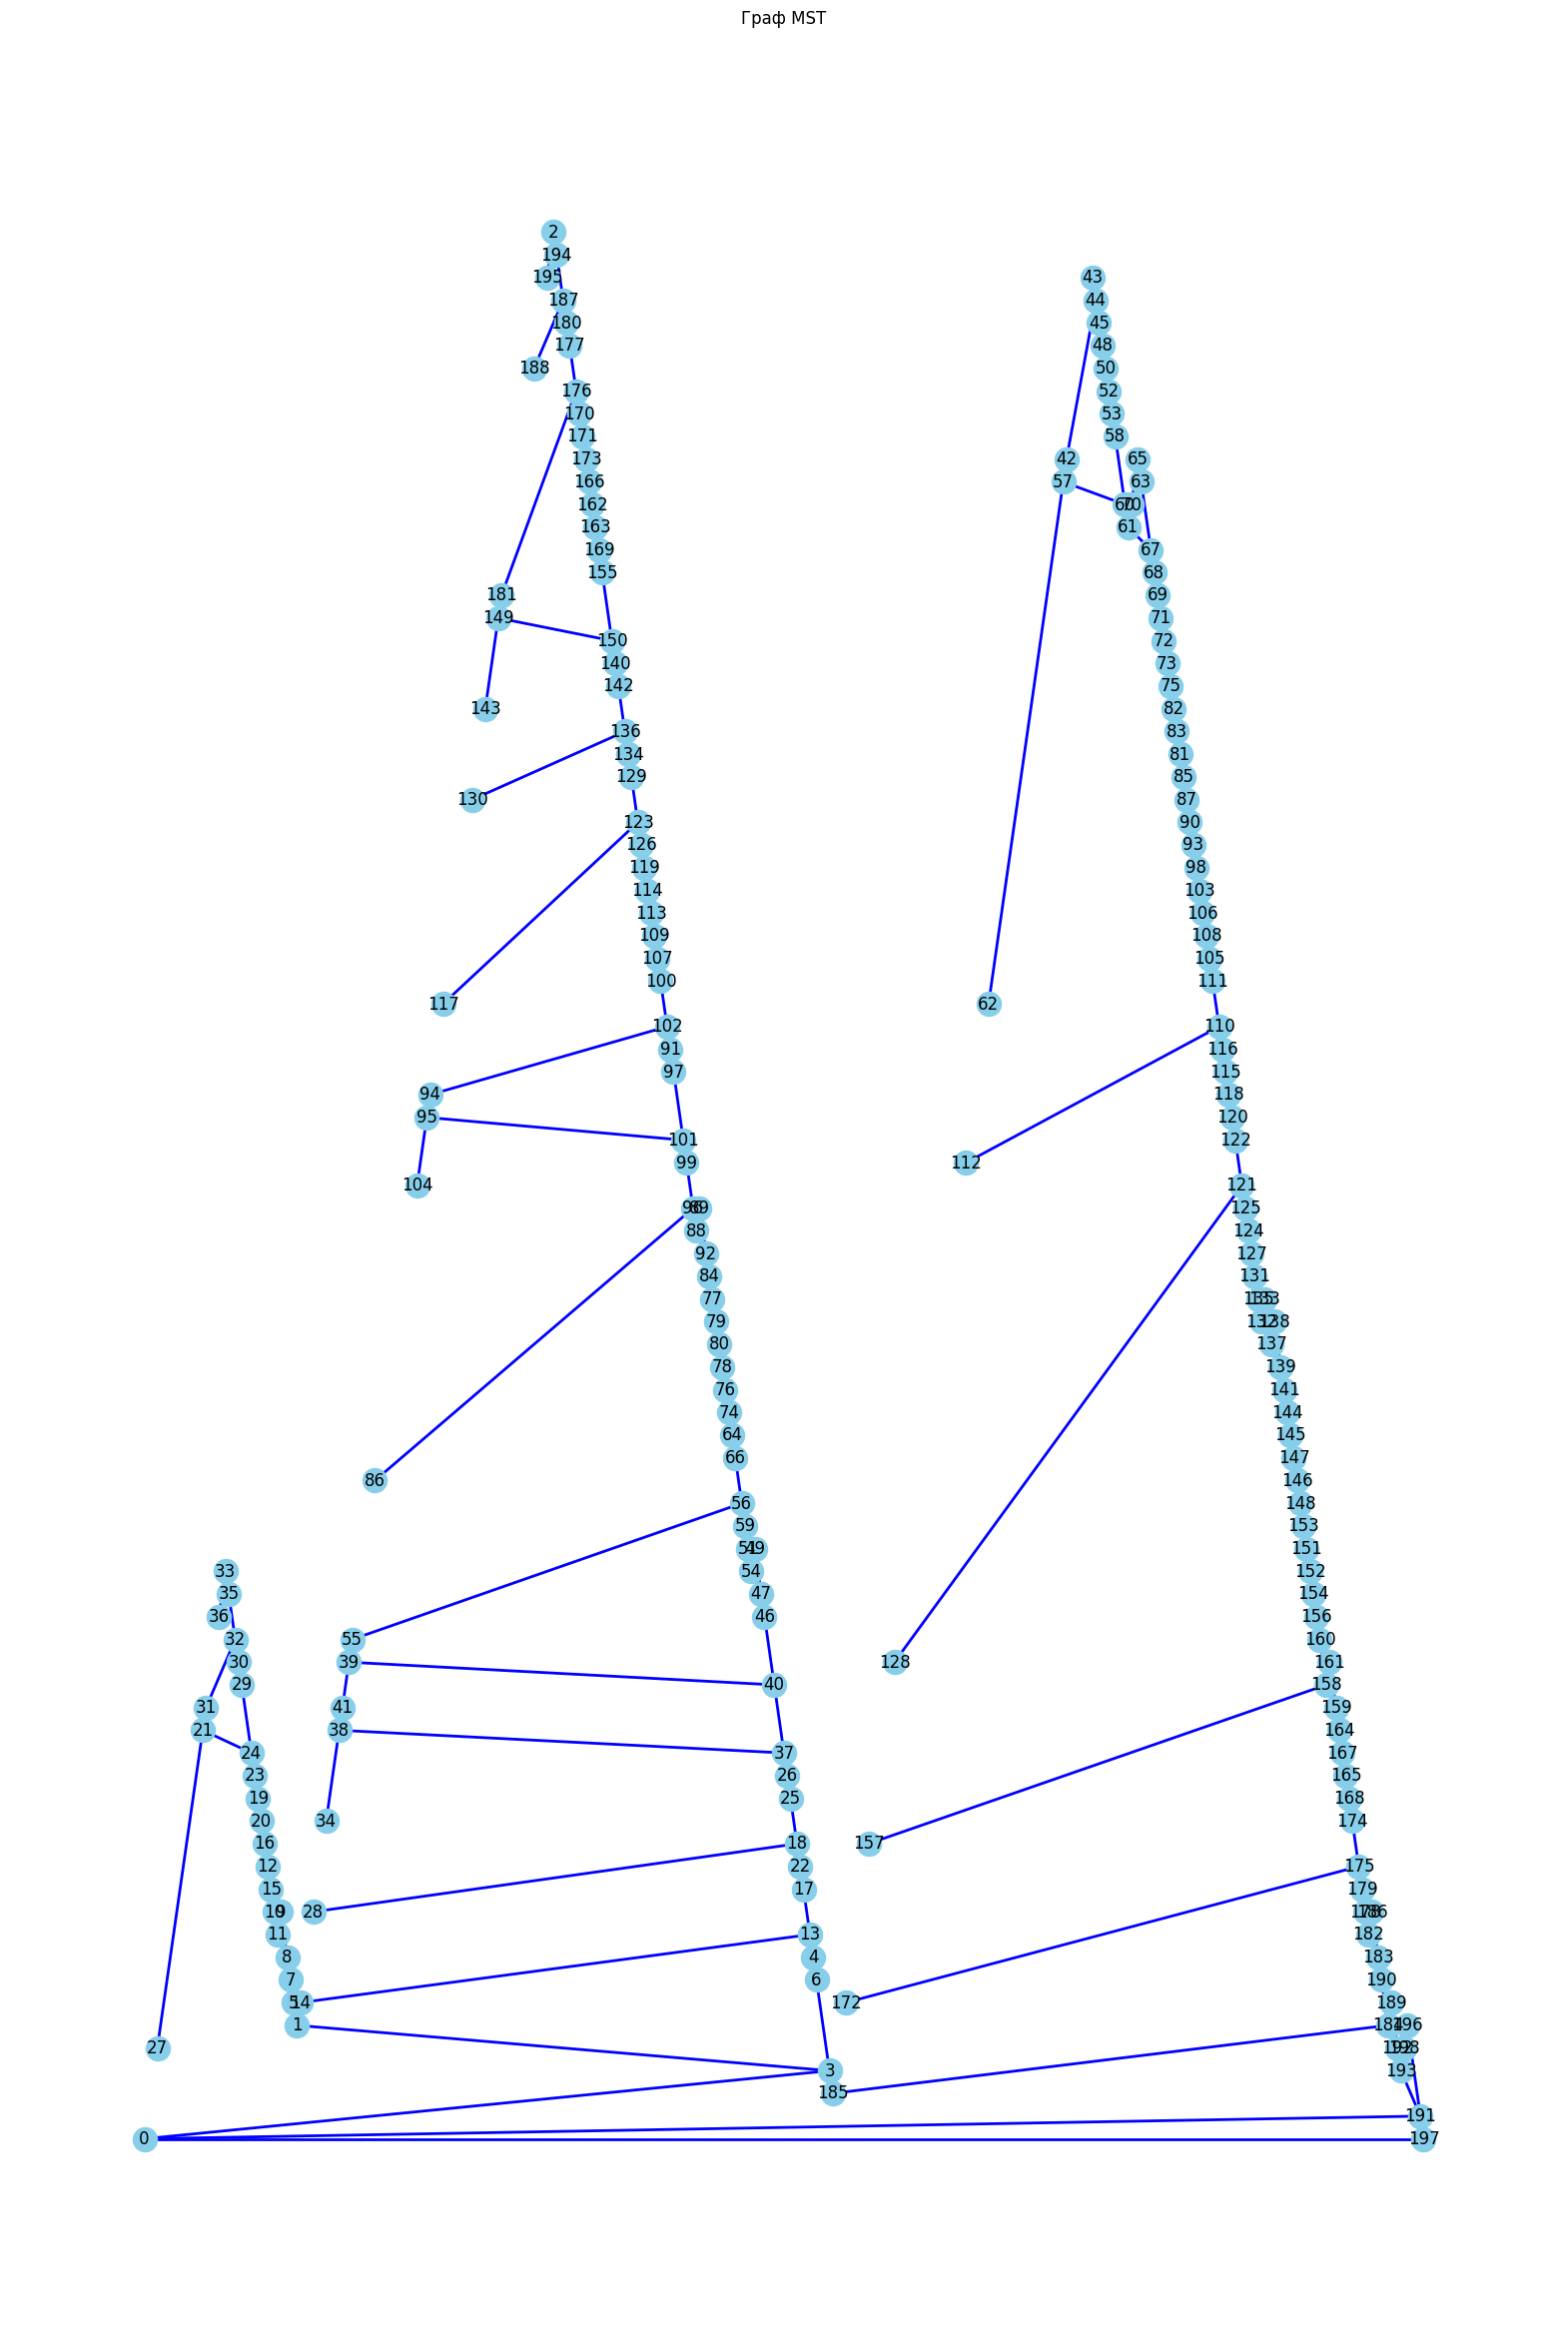

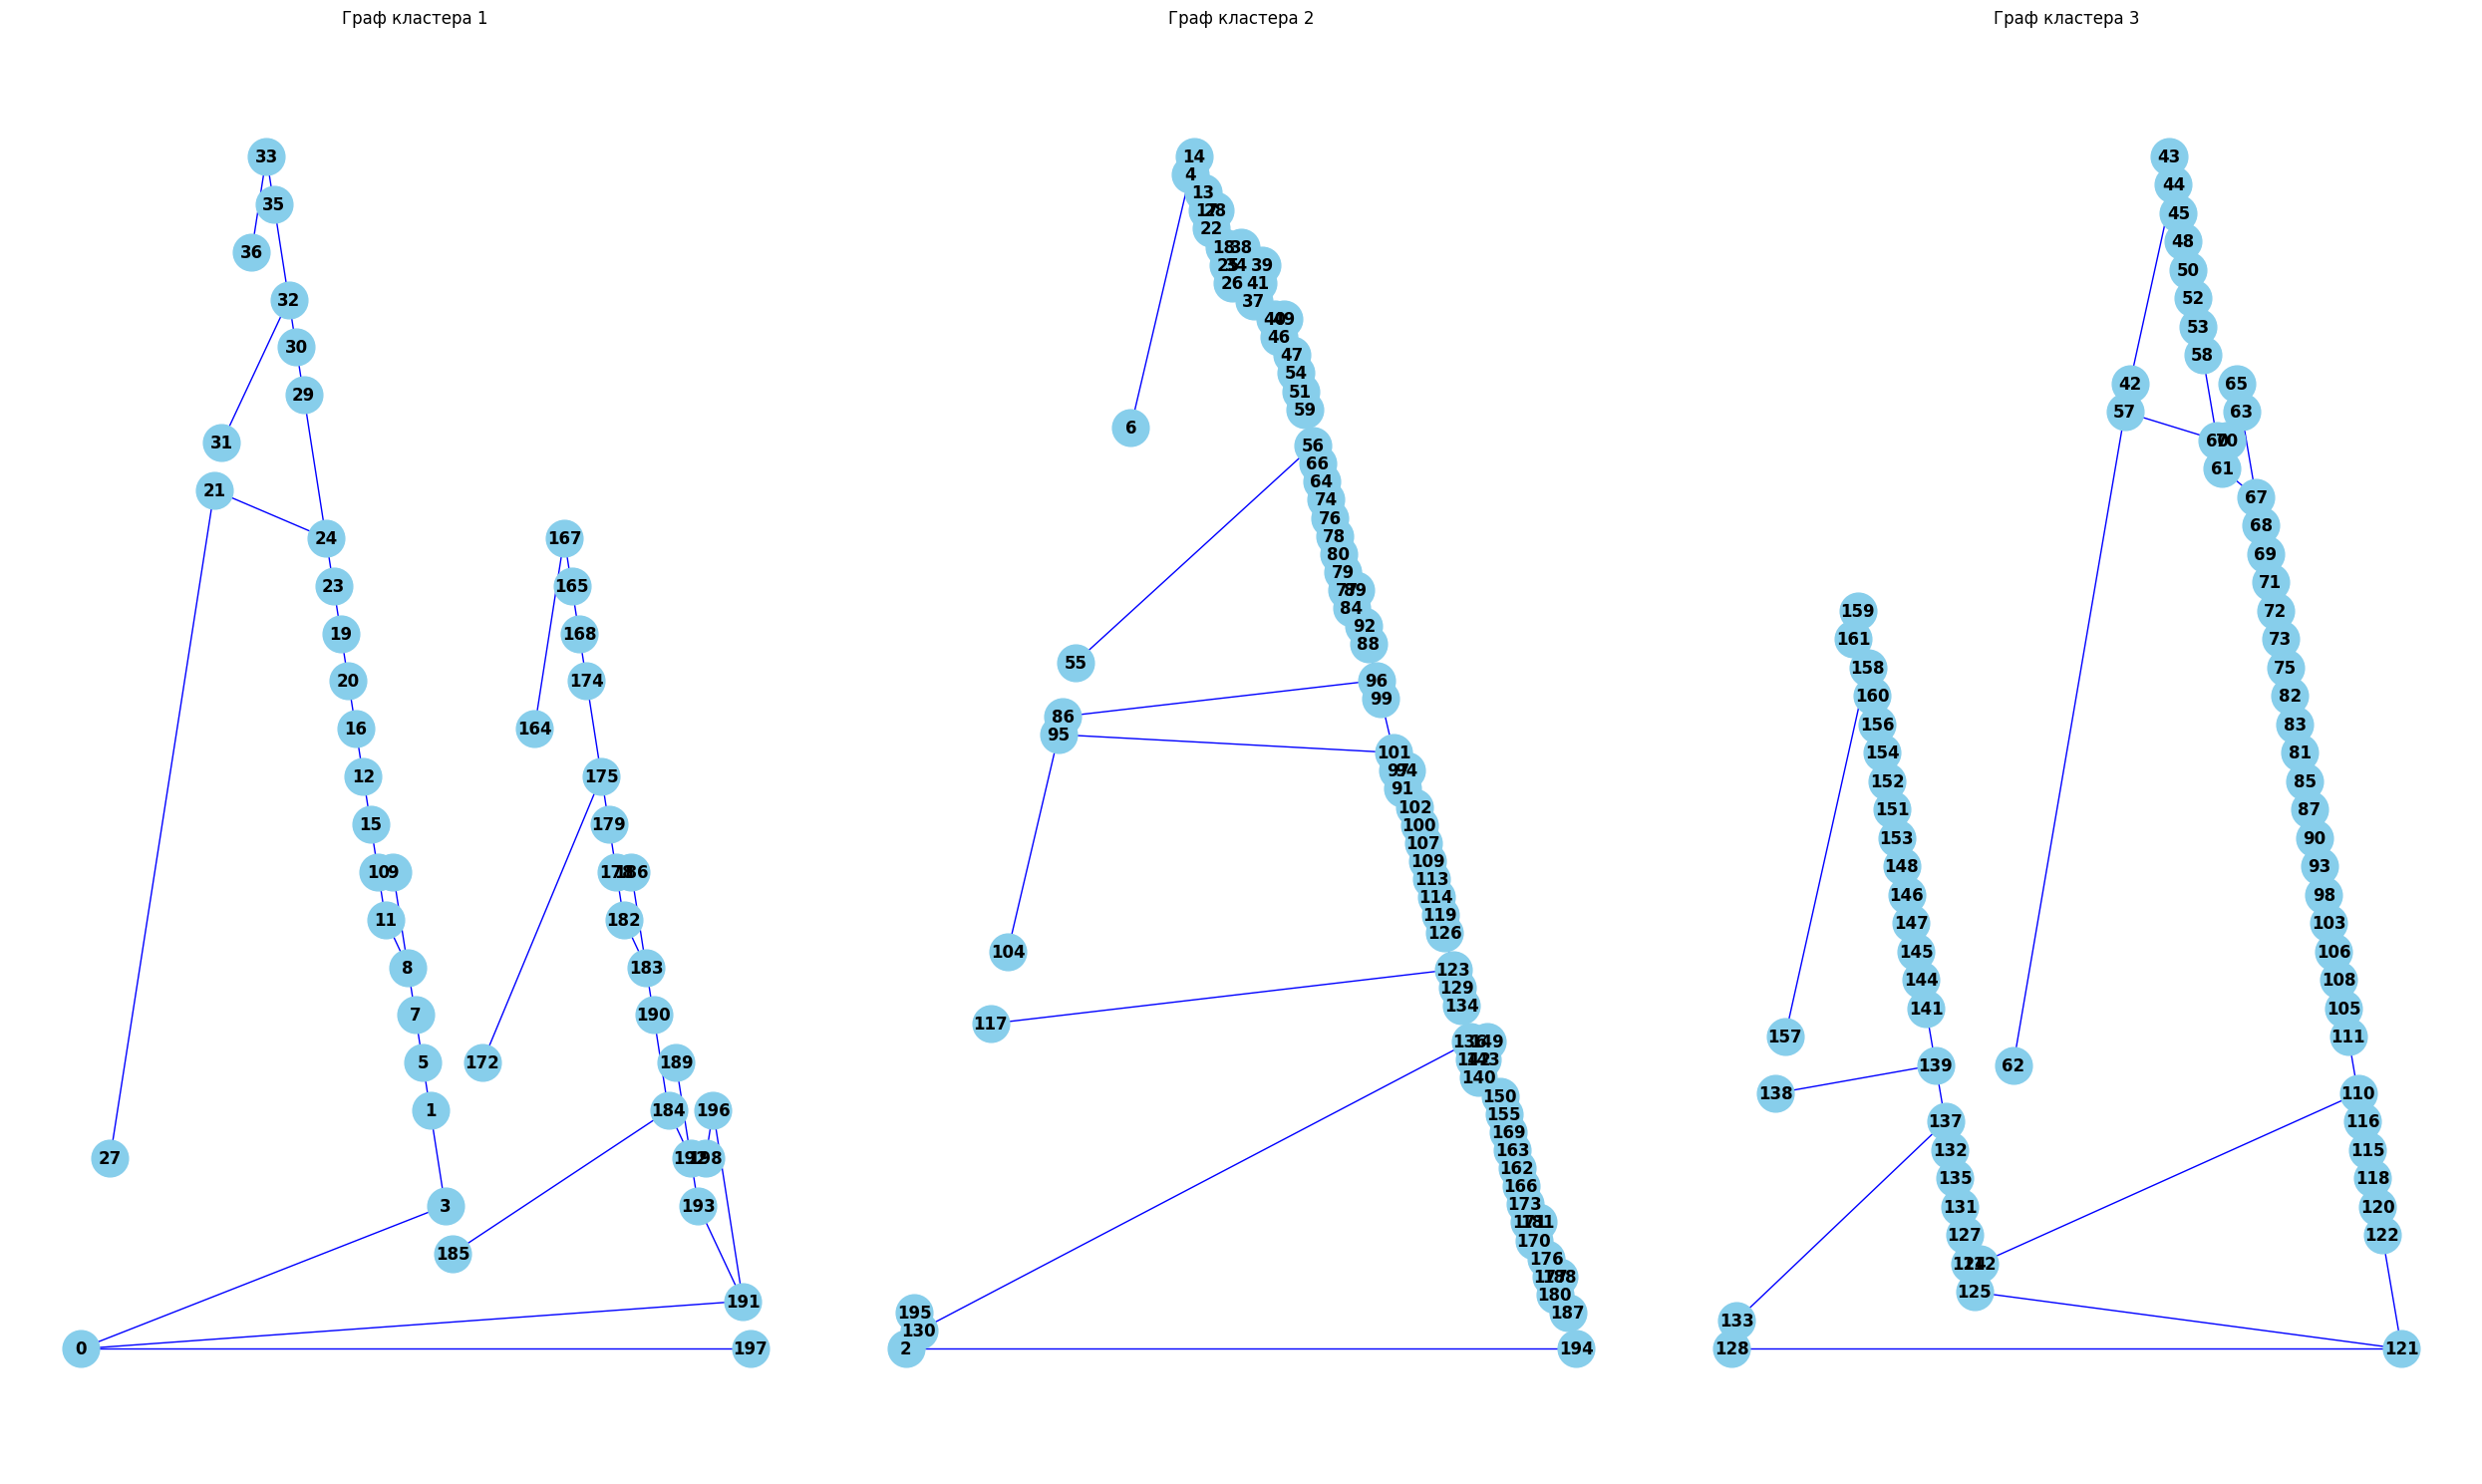

Кластер 1: [0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 19, 20, 21, 23, 24, 27, 29, 30, 31, 32, 33, 35, 36, 164, 165, 167, 168, 172, 174, 175, 178, 179, 182, 183, 184, 185, 186, 189, 190, 191, 192, 193, 196, 197, 198]
Кластер 2: [2, 4, 6, 13, 14, 17, 18, 22, 25, 26, 28, 34, 37, 38, 39, 40, 41, 46, 47, 49, 51, 54, 55, 56, 59, 64, 66, 74, 76, 77, 78, 79, 80, 84, 86, 88, 89, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 104, 107, 109, 113, 114, 117, 119, 123, 126, 129, 130, 134, 136, 140, 142, 143, 149, 150, 155, 162, 163, 166, 169, 170, 171, 173, 176, 177, 180, 181, 187, 188, 194, 195]
Кластер 3: [42, 43, 44, 45, 48, 50, 52, 53, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 75, 81, 82, 83, 85, 87, 90, 93, 98, 103, 105, 106, 108, 110, 111, 112, 115, 116, 118, 120, 121, 122, 124, 125, 127, 128, 131, 132, 133, 135, 137, 138, 139, 141, 144, 145, 146, 147, 148, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161]


In [213]:
G__inf, clusters_mst_inf = MST_clustering(3, sim_matrix_chebyshev)

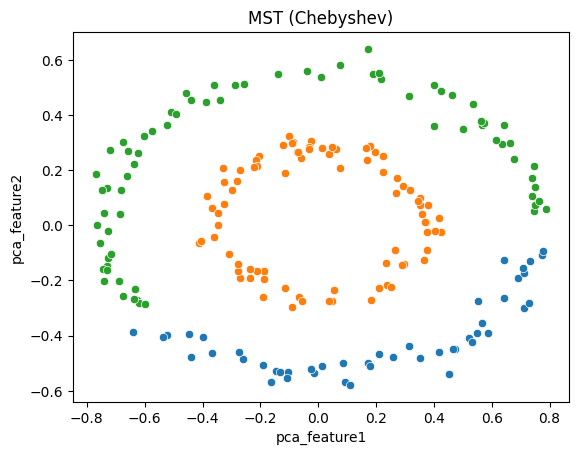

In [214]:
plt.title('MST (Chebyshev)')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_mst_inf)):
    sns.scatterplot(x=data_2d[list(clusters_mst_inf[i])][:, 0], y=data_2d[list(clusters_mst_inf[i])][:, 1])

MST с расстояниями минковсого с p=4  и p=2 (Евклидово) схожим образом кластеризуют объекты, однако расстояние Чебышева привело к сильно отличному разбиению.

#### Кластеризация методом K-Means

In [215]:
kmeans = KMeans(n_clusters=3, n_init=50)
kmeans.fit(X)
labels_kmeans = kmeans.predict(X)
clusters_kmeans = []
for i in range(3):
    cluster =  np.arange(0, 199)[labels_kmeans == i]
    clusters_kmeans.append(set(cluster))
for i, cluster in enumerate(clusters_kmeans, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 181]
Кластер 2: [34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]
Кластер 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 177, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198]


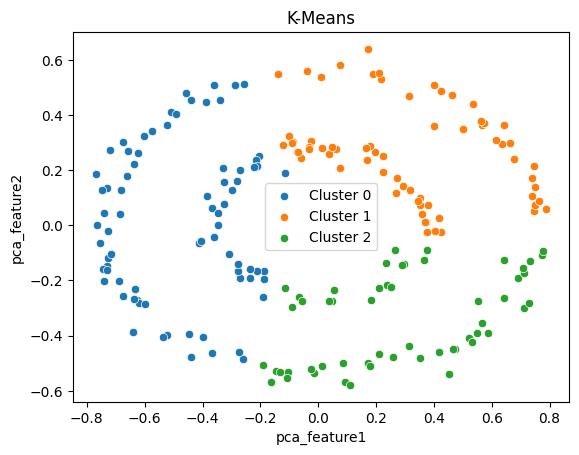

In [216]:
plt.title('K-Means')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_kmeans)):
    sns.scatterplot(x=data_2d[list(clusters_kmeans[i])][:, 0], y=data_2d[list(clusters_kmeans[i])][:, 1],
                    label=f'Cluster {i}')

Чтобы нарисовать центры, полученные алгоритмом, применим его к данным вложенным в двумерие

In [217]:
kmeans = KMeans(n_clusters=3, n_init=50)
kmeans.fit(data_2d)
labels = kmeans.predict(data_2d)
clusters_kmeans = []
for i in range(3):
    cluster =  np.arange(0, 199)[labels_kmeans == i]
    clusters_kmeans.append(set(cluster))
for i, cluster in enumerate(clusters_kmeans, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 181]
Кластер 2: [34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]
Кластер 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 177, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198]


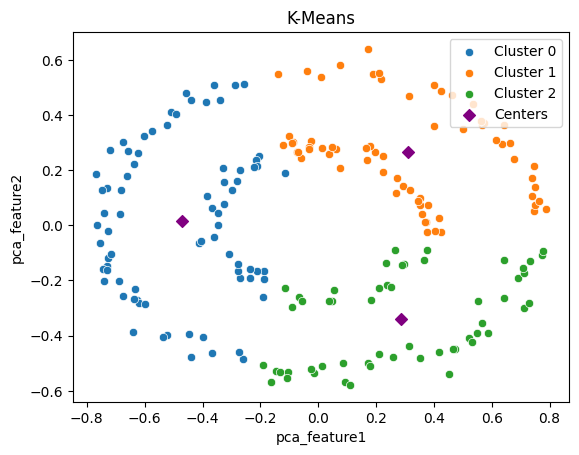

In [218]:
centroids = kmeans.cluster_centers_

plt.title('K-Means')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_kmeans)):
    sns.scatterplot(x=data_2d[list(clusters_kmeans[i])][:, 0], y=data_2d[list(clusters_kmeans[i])][:, 1],
                    label=f'Cluster {i}')
    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='D', label='Centers', color='purple')
plt.legend(loc='upper right')

#### Кластеризация EM-алгоритмом

In [180]:
gmm = GaussianMixture(n_components=3, covariance_type="full", random_state=54)
gmm.fit(X)
labels_em = gmm.predict(X)
clusters_em = []
for i in range(3):
    cluster =  np.arange(0, 199)[labels_em == i]
    clusters_em.append(set(cluster))
for i, cluster in enumerate(clusters_em, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106]
Кластер 2: [105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 181]
Кластер 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198]


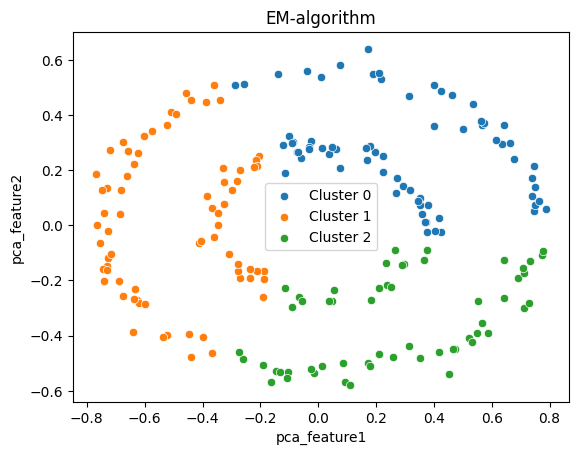

In [181]:
plt.title('EM-algorithm')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_em)):
    sns.scatterplot(x=data_2d[list(clusters_em[i])][:, 0], y=data_2d[list(clusters_em[i])][:, 1],
                    label=f'Cluster {i}')

Кластеризация EM-алгоритмом на двумерных данных для визуализации результатов

In [182]:
gmm = GaussianMixture(n_components=3, covariance_type="full", random_state=54)
gmm.fit(data_2d)
labels = gmm.predict(data_2d)
clusters_em = []
for i in range(3):
    cluster =  np.arange(0, 199)[labels_em == i]
    clusters_em.append(set(cluster))
for i, cluster in enumerate(clusters_em, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106]
Кластер 2: [105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 181]
Кластер 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198]


/tmp/ipykernel_2286/78252592.py:8: UserWarning: Log scale: values of z <= 0 have been masked
  CS = plt.contour(


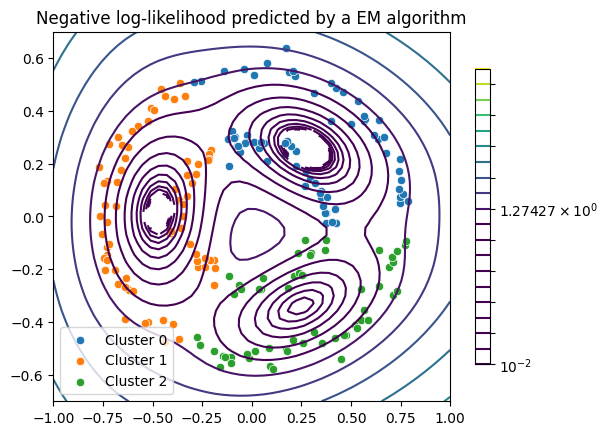

In [183]:
x = np.linspace(-1, 1)
y = np.linspace(-0.7, 0.7)
X_, Y_ = np.meshgrid(x, y)
XX = np.array([X_.ravel(), Y_.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X_.shape)

CS = plt.contour(
    X_, Y_, Z, norm=LogNorm(vmin=1.0, vmax=100), levels=np.logspace(-2, 2, 20)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
# plt.scatter(data_2d[:, 0], data_2d[:, 1], 0.8)
for i in range(len(clusters_em)):
    sns.scatterplot(x=data_2d[list(clusters_em[i])][:, 0], y=data_2d[list(clusters_em[i])][:, 1],
                    label=f'Cluster {i}')

plt.title("Negative log-likelihood predicted by a EM algorithm")
plt.axis("tight")
plt.show()

Линии уровня на иллюстрации выше показывают плотность вероятности гауссовых компонент

#### Кластеризация Unnormalized Spectral методом

In [184]:
W = sim_matrix
D = np.diag([W.shape[0] for _ in range(W.shape[0])])
L = D - W

In [185]:
eig_vals, eig_vecs = np.linalg.eigh(L)
eig_vecs_3 = eig_vecs[:, :3]
kmeans = KMeans(n_clusters=3, n_init=50)
labels_spectral = kmeans.fit_predict(eig_vecs_3)
clusters_spectral = []
for i in range(3):
    cluster =  np.arange(0, 199)[labels_spectral == i]
    clusters_spectral.append(set(cluster))
for i, cluster in enumerate(clusters_spectral, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
Кластер 2: [0, 1, 2, 3, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198]
Кластер 3: [73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 142]


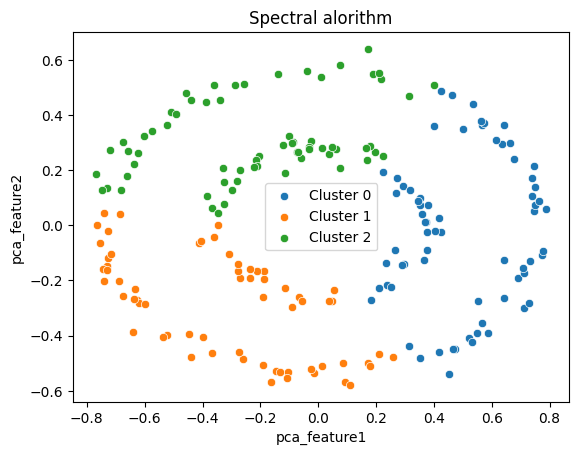

In [186]:
plt.title('Spectral alorithm')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_spectral)):
    sns.scatterplot(x=data_2d[list(clusters_spectral[i])][:, 0], y=data_2d[list(clusters_spectral[i])][:, 1],
                    label=f'Cluster {i}')

#### Подсчет RAND индекса

In [219]:
rand_idx_matrix = np.zeros((7, 7))

for i, m1 in enumerate([clusters_mst_euc, clusters_mst_p4, clusters_mst_inf, clusters_kmeans, clusters_em, clusters_spectral]):
    for j, m2 in enumerate(
        [clusters_mst_euc, clusters_mst_p4, clusters_mst_inf, clusters_kmeans, clusters_em, clusters_spectral]
    ):
        rand_idx_matrix[i, j] = get_rand_index(m1, m2)

rand_idx_matrix

array([[1.        , 1.        , 0.78108336, 0.49587717, 0.48369371,
        0.38930696, 0.        ],
       [1.        , 1.        , 0.78108336, 0.49587717, 0.48369371,
        0.38930696, 0.        ],
       [0.78108336, 0.78108336, 1.        , 0.46589217, 0.47633291,
        0.37346954, 0.        ],
       [0.49587717, 0.49587717, 0.46589217, 1.        , 0.94866935,
        0.50270394, 0.        ],
       [0.48369371, 0.48369371, 0.47633291, 0.94866935, 1.        ,
        0.49854673, 0.        ],
       [0.38930696, 0.38930696, 0.37346954, 0.50270394, 0.49854673,
        1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]])

In [220]:
random_partitions = [r_partition(3, 199) for i in range(100)]

In [221]:
for i, m in enumerate([clusters_mst_euc, clusters_mst_p4, clusters_mst_inf, clusters_kmeans, clusters_em, clusters_spectral]):
    mean_rand_idx_vs_randompart = (
        sum([get_rand_index(m, r) for r in random_partitions]) / 100
    )
    rand_idx_matrix[i, 6] = rand_idx_matrix[6, i] = mean_rand_idx_vs_randompart

In [222]:
rand_idx_matrix[6, 6] = sum([sum([get_rand_index(r1, r2) for r1 in random_partitions]) for r2 in random_partitions]) / 100**2

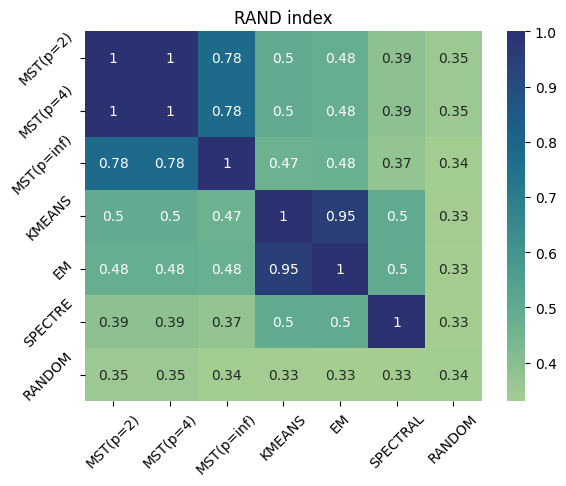

In [223]:
plt.title("RAND index")
g = sns.heatmap(
    rand_idx_matrix,
    annot=True,
    xticklabels=["MST(p=2)", "MST(p=4)", "MST(p=inf)", "KMEANS", "EM", "SPECTRAL", "RANDOM"],
    yticklabels=["MST(p=2)", "MST(p=4)", "MST(p=inf)", "KMEANS", "EM", "SPECTRE", "RANDOM"],
    cmap="crest",
)
if g.get_yticklabels():
    g.set_yticklabels(labels=g.get_yticklabels(), rotation=45)
if g.get_xticklabels():
    g.set_xticklabels(g.get_xticklabels(), rotation=45)

Можно с уверенностью сказать, что MST с p=2 и p=4 получает одинаковые разбиения, однако расстояние Чебышева, скорее всего в силу своей предельной природы создало слегка отличное разбиение MST.
Также ЕМ алгоритм кластеризовал схожим с KMeans образом.

Можно выделить две группы схожих методов по RAND индексам - MST и пара EM-Kmeans.

Примечание: можно заметить, что средние значения RAND индекса между любыми методами и случайным, как и случайного с собой примерно равно 1/(количество кластеров) ~= 0.33; что, вероятно, позволяет воспринимать такое значение как некое калибровочное или базовое.

#### Подсчет функции модулярности

In [192]:
mfn_rand = []

for k in range(0, 100):
    rpart = r_partition(3, 199)
    mfn_rand.append(nx.community.modularity(G, rpart))

In [225]:
for part, part_name in zip(
    [clusters_mst_euc, clusters_mst_p4, clusters_mst_inf, clusters_kmeans, clusters_em, clusters_spectral],
    ["MST(p=2)", "MST(p=4)", "MST(p=inf)", "KMEANS", "EM", "SPECTRAL"],
):
    print(f"{part_name} clustering modularity value:", nx.community.modularity(G, part))
print("RANDOM clustering modularity value:", sum(mfn_rand) / 100)

MST(p=2) clustering modularity value: 0.0194914596681721
MST(p=4) clustering modularity value: 0.0194914596681721
MST(p=inf) clustering modularity value: 0.020817054047382925
KMEANS clustering modularity value: 0.042068053781171386
EM clustering modularity value: 0.042063741974815536
SPECTRAL clustering modularity value: 0.042462554066928865
RANDOM clustering modularity value: -0.0033281729511170487


#### Подсчет Silhouette Score

In [226]:
sil_rand = []

for k in range(0, 100):
    rpart = r_partition(2, 199)
    sil_rand.append(silhouette_score(X, get_labels_from_clusters(rpart)))

In [227]:
for part, part_name in zip(
    [clusters_mst_euc, clusters_mst_p4, clusters_mst_inf, clusters_kmeans, clusters_em, clusters_spectral],
    ["MST(p=2)", "MST(p=4)", "MST(p=inf)", "KMEANS", "EM", "SPECTRAL"],
):
    cur_labels = get_labels_from_clusters(part)
    print(f'{part_name} silhouette score: {silhouette_score(X, cur_labels)}')
    
print("RANDOM silhouette score:", sum(sil_rand) / 100)

MST(p=2) silhouette score: 0.13953474113071754
MST(p=4) silhouette score: 0.13953474113071754
MST(p=inf) silhouette score: 0.15398017975442965
KMEANS silhouette score: 0.39246755138441985
EM silhouette score: 0.39006446179224485
SPECTRAL silhouette score: 0.3927188639443766
RANDOM silhouette score: 0.0012762637300522532


Скорее всего, то, что значения silhouette score в MST получились меньше, чем у KMeans, EM и спектрального метода связано с тем, что только MST выделяет внутреннее кольцо в отдельный кластер, что из определения silhouette score ведет к его пониженным значениям.

## Оценка оптимального количества кластеров известными методами

#### 1) Оценка оптимального количества кластеров методом локтя

Для реализации данного метода, мы кластерезуем наши наблюдения некоторое количество раз варьируя k (количество кластеров от 1 до некоторого верхнего значения). Для каждого k мы считаем WCSS (within-cluster sum of squares) и строим график зависимости WCSS от k.

Суть метода заключается в том, что оптимальное k можно определить по графику: точка, соответсвующая k будет "локтевой", то есть если увеличивать k относительно оптимального, WCSS будет оставаться на плато.

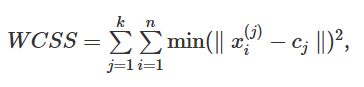

Для определения локтевой точки будем использовать ансамбль из двух линейных регрессий, точкой перелома (локтя) выберем ту, при разбиении по которой получается оптимальное значение R2. Ссылка на статью с подробным описанием метода:

 https://cyberleninka.ru/article/n/novye-instrumenty-upravleniya-kachestvom-metod-poiska-loktevoy-tochki-dlya-opredeleniya-priemlemyh-znacheniy-metrik-mashinnogo/viewer

In [196]:
def two_reg_elbow_find(metrics):
    R2_scores = []
    left_preds, right_preds = [], []
    x = np.arange(1, len(metrics)+1)[..., np.newaxis]
    for i in range(len(metrics)):
        L1, L2 = LinearRegression(), LinearRegression()
        left_x, right_x = x[:i,...], x[i:,...]
        left_y, right_y = metrics[:i], metrics[i:]

        if len(left_x) > 0:
            l_preds = L1.fit(left_x, left_y).predict(left_x)
        else:
            l_preds = np.asarray([])

        left_preds.append(l_preds.copy())

        if len(right_x) > 0:
            r_preds = L2.fit(right_x, right_y).predict(right_x)
        else:
            r_preds = np.asarray([])

        right_preds.append(r_preds.copy())
        
        R2_scores.append(r2_score(np.concatenate([left_y,right_y]), np.concatenate([l_preds, r_preds])))

    R2_scores = np.asarray(R2_scores)
    elbow_idx = np.argmax(R2_scores)+1

    return elbow_idx, left_preds[elbow_idx-1], right_preds[elbow_idx-1]

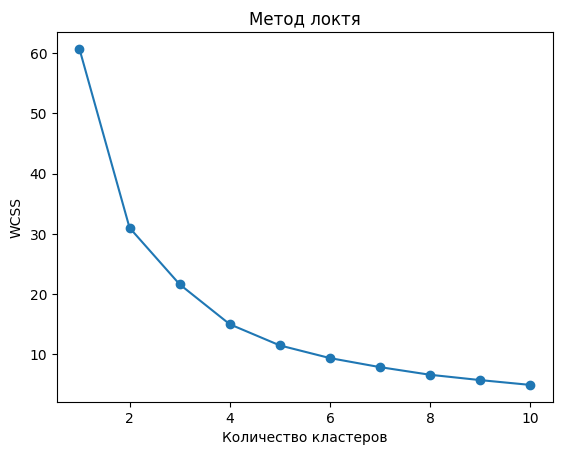

In [197]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=54).fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.title('Метод локтя')
plt.show()

In [198]:
wcss_elbow, wcss_lcfs, wcss_rcfs = two_reg_elbow_find(wcss)

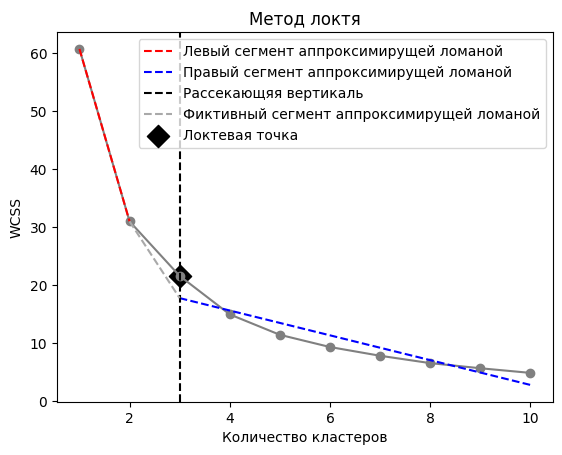

In [199]:
plt.plot(range(1, 11), wcss, marker='o', color="grey")
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.title('Метод локтя')

plt.plot(range(1, wcss_elbow), wcss_lcfs, linestyle="--", color="red", label="Левый сегмент аппроксимирущей ломаной")
plt.plot(range(wcss_elbow, 11), wcss_rcfs, linestyle="--", color="blue", label="Правый сегмент аппроксимирущей ломаной")
plt.axvline(x=wcss_elbow, linestyle="--", label="Рассекающяя вертикаль", color="k")
plt.plot([wcss_elbow-1, wcss_elbow], [wcss_lcfs[-1], wcss_rcfs[0]], linestyle="--", color="darkgrey", label="Фиктивный сегмент аппроксимирущей ломаной")
plt.scatter(wcss_elbow, wcss[wcss_elbow-1], marker="D", label="Локтевая точка", color="k", s=128)
plt.legend()
plt.show()

In [202]:
print(f'Локтевая точка: {wcss_elbow}')

Локтевая точка: 3


По методу локтя точно нельзя сказать, какое количество кластеров оптимально в данном случае, ведь на графике нельзя однозначно выделить "локтевую" точку. Проблема заключается в том, что при такой топологии данных KMeans плохо с правляется с задачей

#### 2) Оценка оптимального количества кластеров с помощью Silhouette score

In [200]:
sil_scores = [0]
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init=50)
    kmeans.fit(X)
    cur_labels = kmeans.predict(X)
    sil_scores.append(silhouette_score(X, cur_labels))

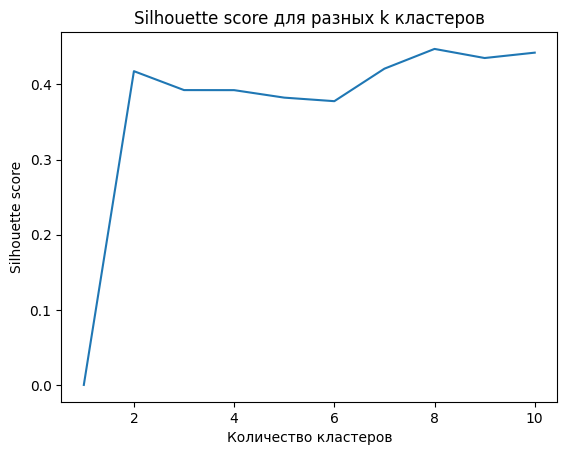

In [201]:
plt.title('Silhouette score для разных k кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette score')
plt.plot(list(range(1, 11)), sil_scores)

По графику трудно сделать вывод об оптимальном количестве кластеров.

Для этого набора данных можно утверждать, что оптимальное количество кластеров наиболее хорошо определяется визуально, так как на 2D-карте отчетливо видно 2 группы наблюдений. На двумерном графике видна достаточно нетривиальная структура кластеров, которую такие алгоритмы как K-Means не умеют определять. Вряд ли удастся с помощью какой-либо численной метрики определить оптимальное число кластеров, так как все они (по крайней мере те, которые нам удалось найти в литературе) основаны на расстояниях внутри кластеров.